# CIS 5450 Group Project

- Andrew Kim
- Joseph Manuel
- Chris Stewart
- Joe Suh

# Introduction / Background

Our primary objective is to explore the myriad of health issues individuals face and understand how various indicators contribute variables like mortality rates. By leveraging data exploration and modeling techniques, we aim to shed some light on the web of factors influencing public health outcomes.

In addition, our secondary objective is to examine the correlation between poor air quality and adverse health metrics. We will compare datasets to discern if there's a notable link between degraded air quality and deteriorating health indicators. Specifically, we'll investigate the impact of pollutants like carbon monoxide, ozone, and nitrogen dioxide, assessing their potential influence on health outcomes.

Through this dual-pronged approach, we hope to gain a better understanding of health dynamics and environmental influences.

We are using health nutrition data from a [World Bank Health Nutrition and Population Statistics](https://www.kaggle.com/datasets/theworldbank/health-nutrition-and-population-statistics) dataset hosted on Kaggle. We are also using air quality data from the [World Health Organization (WHO) Air quality database](https://www.who.int/data/gho/data/themes/air-pollution/who-air-quality-database). We are able to merge these two datasets to be able to investigate these relationships.

# Imports/Setup

In [ ]:
%%capture

!apt install libkrb5-dev
!pip install pandas
!pip install seaborn --user
!pip install plotly --user
!pip install imageio --user
!pip install folium --user
!pip install geonamescache
!pip install slug
!pip install basemap

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
import seaborn as sns
import requests
from geonamescache import GeonamesCache
import slug
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

In [ ]:
%%capture
!apt update
!pip install kaggle

# **Part I:** Preprocessing

## 1.1 Data Loading and Preprocessing

First, we load the Population Health Nutrition data set from Kaggle.

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the kaggle directory
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download dataset
!!kaggle datasets download -d theworldbank/health-nutrition-and-population-statistics

['Downloading health-nutrition-and-population-statistics.zip to /content',
 '',
 '  0% 0.00/14.0M [00:00<?, ?B/s]',
 ' 21% 3.00M/14.0M [00:00<00:00, 30.7MB/s]',
 ' 43% 6.00M/14.0M [00:00<00:00, 28.6MB/s]',
 ' 86% 12.0M/14.0M [00:00<00:00, 42.8MB/s]',
 '',
 '100% 14.0M/14.0M [00:00<00:00, 38.5MB/s]']

In [ ]:
# Unzip folder in Colab content folder
!unzip health-nutrition-and-population-statistics

Archive:  health-nutrition-and-population-statistics.zip
  inflating: data.csv                


In [ ]:
# TO-DO: Read the csv files and save it to dataframes
df_pop_health = pd.read_csv('data.csv')

In [ ]:
# Check first 5 rows of population health data
df_pop_health.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 60
0,Arab World,ARB,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,133.555013,134.159119,134.857912,134.504576,134.105211,133.569626,...,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,NaN,NaN
3,Arab World,ARB,Adults (ages 15+) and children (0-14 years) li...,SH.HIV.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,Adults (ages 15+) and children (ages 0-14) new...,SH.HIV.INCD.TL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Find number of rows with null values
health_nulls = df_pop_health.isnull().any(axis=1).sum()

print("Count of nulls in population health df:", health_nulls)

Count of nulls in population health df: 89010


In [ ]:
# Find number of duplicated rows
health_dups = df_pop_health.duplicated().sum()

print("Count of duplicates in population health df:", health_dups)

Count of duplicates in population health df: 0


In [ ]:
# Drop empty/superfluous column from population health data
df_pop_health.drop(columns=['Unnamed: 60'],inplace=True)

Next, we load the Air Quality dataset that we have downloaded from the WHO website and have hosted on an individual github repository. We also load geospatial graphing files for later use.

In [ ]:
# Define the base URL of the GitHub repository
base_url = 'https://api.github.com/repos/josephlacuna/cis5450/contents/'

# Send a GET request to the GitHub API to get the contents of the directory
response = requests.get(base_url)

if response.status_code == 200:
    files = response.json()  # Convert the JSON response to a Python list

    for file_info in files:
        if file_info['type'] == 'file':
            # Construct the download URL for each file in the directory
            download_url = file_info['download_url']
            file_name = file_info['name']

            # Download the file and save it locally
            file_response = requests.get(download_url)
            if file_response.status_code == 200:
                with open(os.path.join('', file_name), 'wb') as file:
                    file.write(file_response.content)
                print(f'File "{file_name}" downloaded successfully.')
            else:
                print(f'Failed to download file "{file_name}".')
else:
    print('Failed to retrieve directory contents.')

# Load data into DataFrame
df_air_quality = pd.read_csv('who_ambient_air_quality.csv')
df_air_quality.drop(columns=['who_region','iso3','city',
                        'pm10_tempcov','pm25_tempcov','no2_tempcov','population',
                        'latitude','longitude'],inplace=True) #dropping superfluous columns
df_air_quality['year'].replace([np.nan, np.inf, -np.inf], 9999, inplace=True) # setting NA as '9999'
df_air_quality['year'] = df_air_quality['year'].astype(int)
df_air_quality.head(5)

File "ne_10m_admin_0_countries_lakes.README.html" downloaded successfully.
File "ne_10m_admin_0_countries_lakes.VERSION.txt" downloaded successfully.
File "ne_10m_admin_0_countries_lakes.cpg" downloaded successfully.
File "ne_10m_admin_0_countries_lakes.dbf" downloaded successfully.
File "ne_10m_admin_0_countries_lakes.prj" downloaded successfully.
File "ne_10m_admin_0_countries_lakes.shp" downloaded successfully.
File "ne_10m_admin_0_countries_lakes.shx" downloaded successfully.
File "who_ambient_air_quality.csv" downloaded successfully.


,country_name,year,pm10_concentration,pm25_concentration,no2_concentration
0,Spain,2013,23.238,11.491,28.841
1,Spain,2014,27.476,15.878,19.575
2,Spain,2015,25.515,14.004,22.731
3,Spain,2016,23.057,13.160,20.204
4,Spain,2017,26.849,14.114,21.543


In [ ]:
# Find number of rows with null values in air quality df
air_nulls = df_air_quality.isnull().any(axis=1).sum()

print("Count of nulls in air quality df:", air_nulls)

# Find number of duplicated rows in air quality df
air_dups = df_air_quality.duplicated().sum()

print("Count of duplicates in air quality df:", air_dups)

Count of nulls in air quality df: 28234
Count of duplicates in air quality df: 2097


**Context for Pollutant Data Points**

Below is a quick summary of each of the air pollutants that are relevant to our dataset. We potentially want to explore the differences and severities across the pollutants, and have a general understanding of what each pollutant was and the health risks they posed.

**PM10**

PM10 refers to particulate matter that is 10 micrometers or less in diameter. These particles include dust, pollen, and mold. PM10 can be inhaled into the lungs, where they may cause adverse health effects such as respiratory infections, aggravated asthma, chronic bronchitis, and can also contribute to heart disease.


**PM2.5**

PM2.5 consists of fine particulate matter that is 2.5 micrometers or smaller in diameter. These particles are made up of various components including acids (such as nitrates and sulfates), organic chemicals, metals, and soil or dust particles. Due to their small size, PM2.5 particles can penetrate deep into the lungs and even enter the bloodstream, causing more severe health issues than PM10, including lung cancer, cardiovascular episodes, and premature death.


**NO2**

Nitrogen dioxide is a gaseous air pollutant produced by the burning of fossil fuels (cars, trucks, power plants, etc.) and is a part of a group of gases known as nitrogen oxides (NOx). NO2 exposure can irritate airways in the human respiratory system. Longer exposures to elevated concentrations can contribute to the development of asthma and potentially increase susceptibility to respiratory infections.


## 1.2 Exploratory Data Analysis

### 1.2.1 Creating Sub-Dataframes
Here, we are looking to create sub dfs concerned with a particular set of
information in order to streamline analysis. We do this by extracting desired
factors for easier comparison with air quality data and by reducing overhead
by looking at only the indicators we think are interesting. This includes
information concerning infant/maternal mortality, birthing health,
children health, health expenditure, sanitation, and other potentially
interesting factors affected by air quality.

In [ ]:
# Creating SUB DFs
# List of indicators that potentially impact our mortality target variable
of_interest_indicator_names = ['Mortality rate, infant (per 1,000 live births)',
                               'Life expectancy at birth, total (years)',
                               'Low-birthweight babies (% of births)',
                               'Malnutrition prevalence, weight for age (% of children under 5)',
                               'Health expenditure, total (% of GDP)',
                               'Improved water source (% of population with access)',
                               'Poverty headcount ratio at national poverty line (% of population)',
                               'Diabetes prevalence (% of population ages 20 to 79)',
                               'Prevalence of anemia among pregnant women (%)',
                               'Prevalence of tuberculosis (per 100,000 population)'
                               ]
# List of indicators concerned with mortality generally
mortality_indicator_names = ['Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
                             'Life expectancy at birth, total (years)',
                             'Lifetime risk of maternal death (%)',
                             'Maternal mortality ratio (national estimate, per 100,000 live births)',
                             'Mortality rate, under-5 (per 1,000)',
                             'Number of maternal deaths',
                             'Number of under-five deaths'
                             ]
# List of indicators concerned with birth information
birth_indicator_names = ['Birth rate, crude (per 1,000 people)',
                         'Fertility rate, total (births per woman)',
                         'Low-birthweight babies (% of births)',
                         'Prevalence of anemia among pregnant women (%)',
                         ]
df_interest = df_pop_health[df_pop_health['Indicator Name'].isin(of_interest_indicator_names)]
df_mortality = df_pop_health[df_pop_health['Indicator Name'].isin(mortality_indicator_names)]
df_birth = df_pop_health[df_pop_health['Indicator Name'].isin(birth_indicator_names)]

In [ ]:
# Merging the health nutrition of-interest DF with air quality DF

# Reformatting the health nutrition DF to a more suitable and usable form
df_transposed = df_interest.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Value')
df_pivoted = df_transposed.pivot_table(index=['Country Name', 'Country Code', 'Year'], columns='Indicator Name', values='Value').reset_index()
'''
# Casting year values as integers for merging
df_air_quality['year'].replace([np.nan, np.inf, -np.inf], 9999, inplace=True) # setting NA as '9999'
df_pivoted['Year'] = df_pivoted['Year'].astype(int)
df_air_quality['year'] = df_air_quality['year'].astype(int)

#TODO: Joseph: Group air pollution by country -- taking AVG?

# Merging both dataframes on country and year
merged_df = pd.merge(df_pivoted,df_air_quality,left_on=['Country Name','Year'], right_on=['country_name','year'],how='inner')
merged_df.drop(columns=['country_name','year','who_region','iso3','city',
                        'pm10_tempcov','pm25_tempcov','no2_tempcov','population',
                        'latitude','longitude'],inplace=True) #dropping superfluous columns
print(df_pivoted.shape)
print(df_air_quality.shape)
print(merged_df.shape)
merged_df.head(5)
'''
# Casting year values as integers for merging
df_pivoted['Year'] = df_pivoted['Year'].astype(int)

# Taking the average air quality values by country_name and year

avg_air_quality = df_air_quality.groupby(['country_name', 'year']).mean().reset_index()


# Merging both dataframes on country and year
merged_df = pd.merge(df_pivoted,avg_air_quality,left_on=['Country Name','Year'], right_on=['country_name','year'],how='outer')
merged_df.drop(columns=['country_name','year'],inplace=True) #dropping superfluous columns
merged_df['Year'].replace([np.nan, np.inf, -np.inf], 9999, inplace=True) # setting NA as '9999'
merged_df['Year'] = merged_df['Year'].astype(int)
merged_df.head(5)

  country_name  year  pm10_concentration  pm25_concentration  \
0        Spain  2013              23.238              11.491   
1        Spain  2014              27.476              15.878   
2        Spain  2015              25.515              14.004   
3        Spain  2016              23.057              13.160   
4        Spain  2017              26.849              14.114   

   no2_concentration  
0             28.841  
1             19.575  
2             22.731  
3             20.204  
4             21.543  
                                          country_name  year  \
0                                          Afghanistan  2019   
1                                              Albania  2014   
2                                              Albania  2015   
3                                              Albania  2016   
4                                              Albania  2017   
..                                                 ...   ...   
857  occupied Palestinian ter

,Country Name,Country Code,Year,Diabetes prevalence (% of population ages 20 to 79),"Health expenditure, total (% of GDP)",Improved water source (% of population with access),"Life expectancy at birth, total (years)",Low-birthweight babies (% of births),"Malnutrition prevalence, weight for age (% of children under 5)","Mortality rate, infant (per 1,000 live births)",Poverty headcount ratio at national poverty line (% of population),Prevalence of anemia among pregnant women (%),"Prevalence of tuberculosis (per 100,000 population)",pm10_concentration,pm25_concentration,no2_concentration
0,Afghanistan,AFG,1960,NaN,NaN,NaN,32.328512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1961,NaN,NaN,NaN,32.777439,NaN,NaN,240.5,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1962,NaN,NaN,NaN,33.219902,NaN,NaN,236.3,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1963,NaN,NaN,NaN,33.657878,NaN,NaN,232.3,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1964,NaN,NaN,NaN,34.092878,NaN,NaN,228.5,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2.2 Visualizations

To get closer to a comprehensive grasp of the data we have, we employ some data visualization techniques to interpret selected indicators. We will plot some simple line plots and a geospatial representation of some of our indicators. We end up finding that there are varying levels of restrictions we have in our access to the data and factors we desire to analyze. That is to say, we can be aware of these shortcomings from the source data as we interpret our results. Some indicators seem to not have been collected prior to certain years. For example, `Health expenditure` data doesn't seem to be present prior to the 90's.

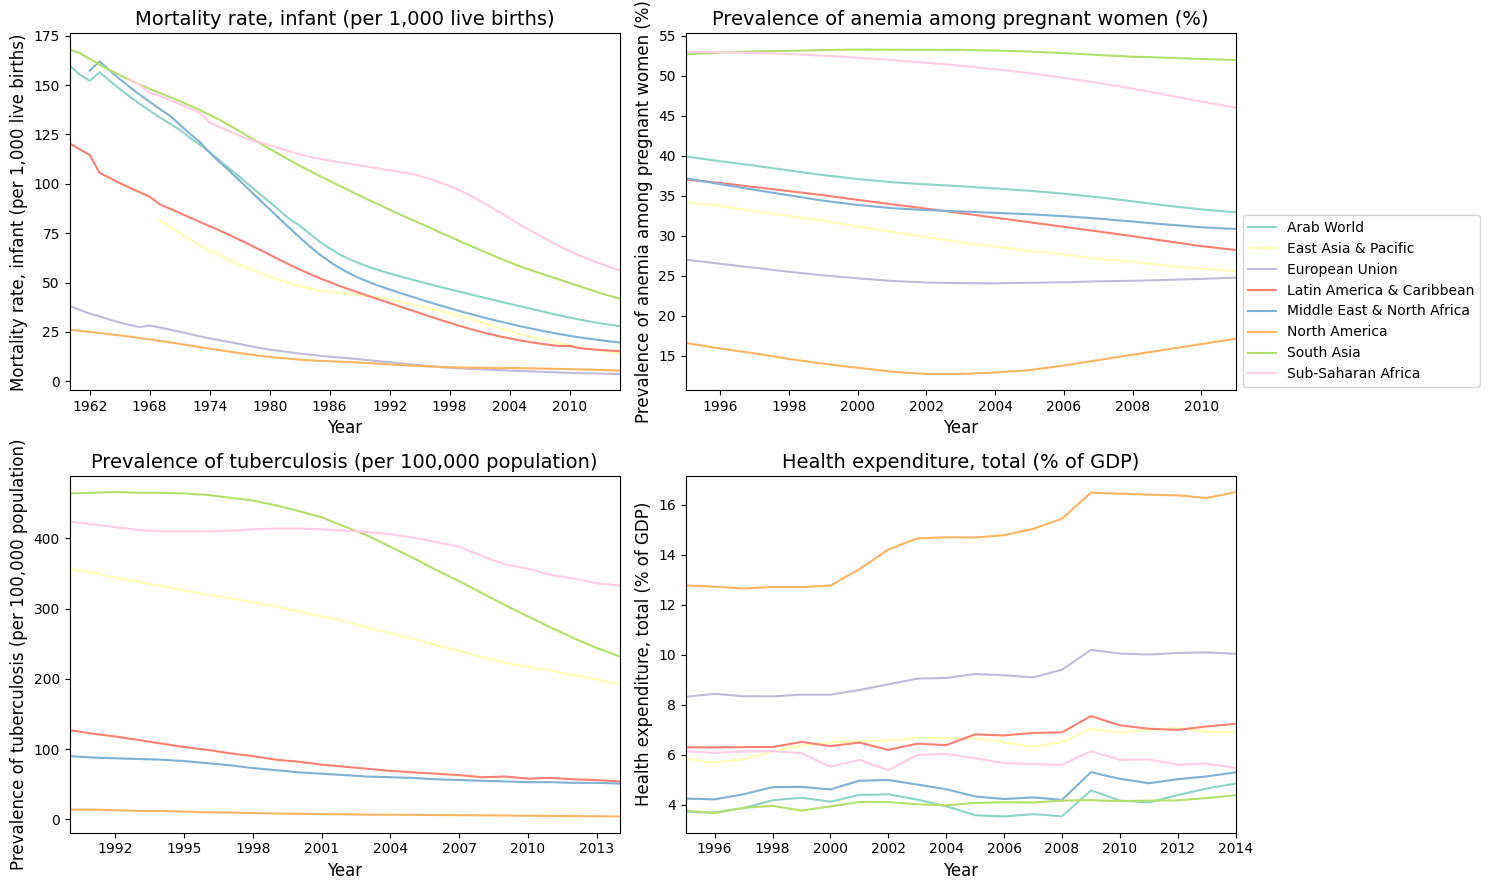

In [ ]:
regions = ['East Asia & Pacific','South Asia','Sub-Saharan Africa', 'Latin America & Caribbean',
           'European Union', 'Middle East & North Africa', 'Arab World', 'North America']

sns.set_palette('Set3')
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figheight(9)
fig.set_figwidth(15)

#Subplot 1
column =  'Mortality rate, infant (per 1,000 live births)'
df = df_pivoted[df_pivoted['Country Name'].isin(regions)][['Country Name', 'Year', column]].rename_axis(None, axis=1).reset_index(drop=True)
sns.lineplot(data=df, x='Year', y=column, hue='Country Name',ax=ax1)
ax1.set_title(column, fontsize=14)
ax1.set_ylabel(column, fontsize=12)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_xlim(1960, 2015)
ax1.get_legend().remove()

#Subplot 2
column = 'Prevalence of anemia among pregnant women (%)'
df = df_pivoted[df_pivoted['Country Name'].isin(regions)][['Country Name', 'Year', column]].rename_axis(None, axis=1).reset_index(drop=True)
sns.lineplot(data=df, x='Year', y=column, hue='Country Name',ax=ax2)
ax2.set_title(column, fontsize=14)
ax2.set_ylabel(column, fontsize=12)
ax2.set_xlabel("Year", fontsize=12)
ax2.set_xlim(1995, 2011)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.25), fontsize=10)


#Subplot 3
column =  'Prevalence of tuberculosis (per 100,000 population)'
df = df_pivoted[df_pivoted['Country Name'].isin(regions)][['Country Name', 'Year', column]].rename_axis(None, axis=1).reset_index(drop=True)
sns.lineplot(data=df, x='Year', y=column, hue='Country Name',ax=ax3)
ax3.set_title(column, fontsize=14)
ax3.set_ylabel(column, fontsize=12)
ax3.set_xlabel("Year", fontsize=12)
ax3.set_xlim(1990, 2014)
ax3.get_legend().remove()

#Subplot 4
column = 'Health expenditure, total (% of GDP)'
df = df_pivoted[df_pivoted['Country Name'].isin(regions)][['Country Name', 'Year', column]].rename_axis(None, axis=1).reset_index(drop=True)
sns.lineplot(data=df, x='Year', y=column, hue='Country Name',ax=ax4)
ax4.set_title(column, fontsize=14)
ax4.set_ylabel(column, fontsize=12)
ax4.set_xlabel("Year", fontsize=12)
ax4.set_xlim(1995, 2014)
ax4.get_legend().remove()

for ax in [ax1, ax2, ax3, ax4]:
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure x-axis ticks are integers

plt.tight_layout()
plt.show()

For further visualization, we have generated geospatial plots for two of our key values moving forwards `Mortality rate, infant (per 1,000 live births)` and `pm10_concentration`. Here we can see some good coverage and availability of data and some limitations as well in the form of the air quality data not covering as much countries as we would like. To note, we have tried several air quality datasets and the dataset from the WHO has been the most clean and comprehensive as well as, most importantly, publically-accessible.

<ipython-input-21-a4000c59ee7f>:42: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = [Polygon(np.array(shape), True)]


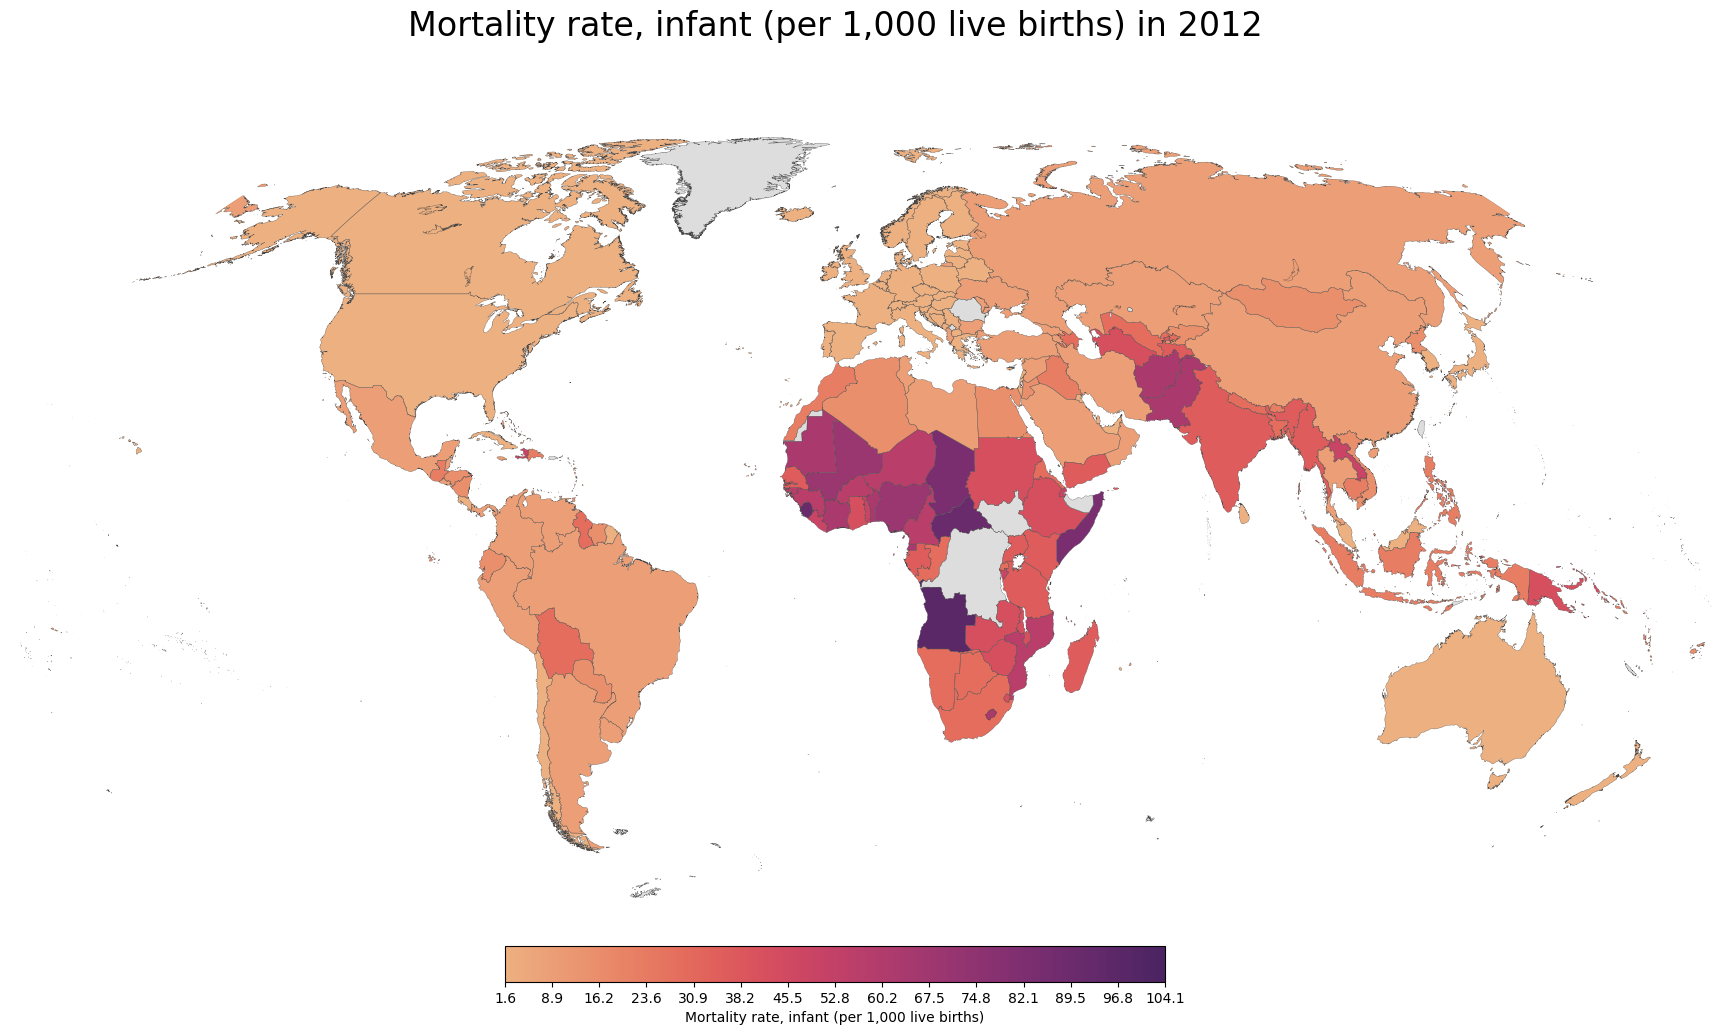

In [ ]:
def create_color_map(feature, year, df):

    # 1 - INPUTS
    shapefile=('ne_10m_admin_0_countries_lakes')
    num_colors = 15
    cols = ['Country Name', 'Country Code', feature]
    title = 'Mortality rate in {}'.format(year)


    # 2 - FILTER COUNTRIES AND GENERATE COLORS

    # Filter countries with country code in GeonamesCache
    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

    # Create DataFrame
    df_map = df[df['Year'] == year][cols]
    df_map = df_map.loc[df_map['Country Code'].isin(iso3_codes)].dropna()

    # Generate color bins based on feature
    values = df_map[feature]
    cm = plt.get_cmap('flare')
    scheme = [cm(i / num_colors) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    df_map['bin'] = np.digitize(values, bins) - 1


    # 3 - GENERATE MAP
    fig = plt.figure(figsize=(22, 12))
    ax = fig.add_subplot(111, facecolor='w', frame_on=False)
    fig.suptitle(feature + ' in {}'.format(year), fontsize=24, y=.95)
    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')
    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)

    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in list(df_map['Country Code']):
            color = '#dddddd'
        else:
            color = scheme[df_map.loc[df_map['Country Code']==iso3, 'bin'].values[0]]
        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='horizontal', ticks=bins, cax=fig.add_axes([0.35, 0.14, 0.3, 0.03]))
    cbar.ax.set_xticklabels([str(round(i, 1)) for i in bins])
    cbar.set_label(feature)
    plt.show()

create_color_map('Mortality rate, infant (per 1,000 live births)', 2012, df_pivoted)

<ipython-input-21-a4000c59ee7f>:42: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = [Polygon(np.array(shape), True)]


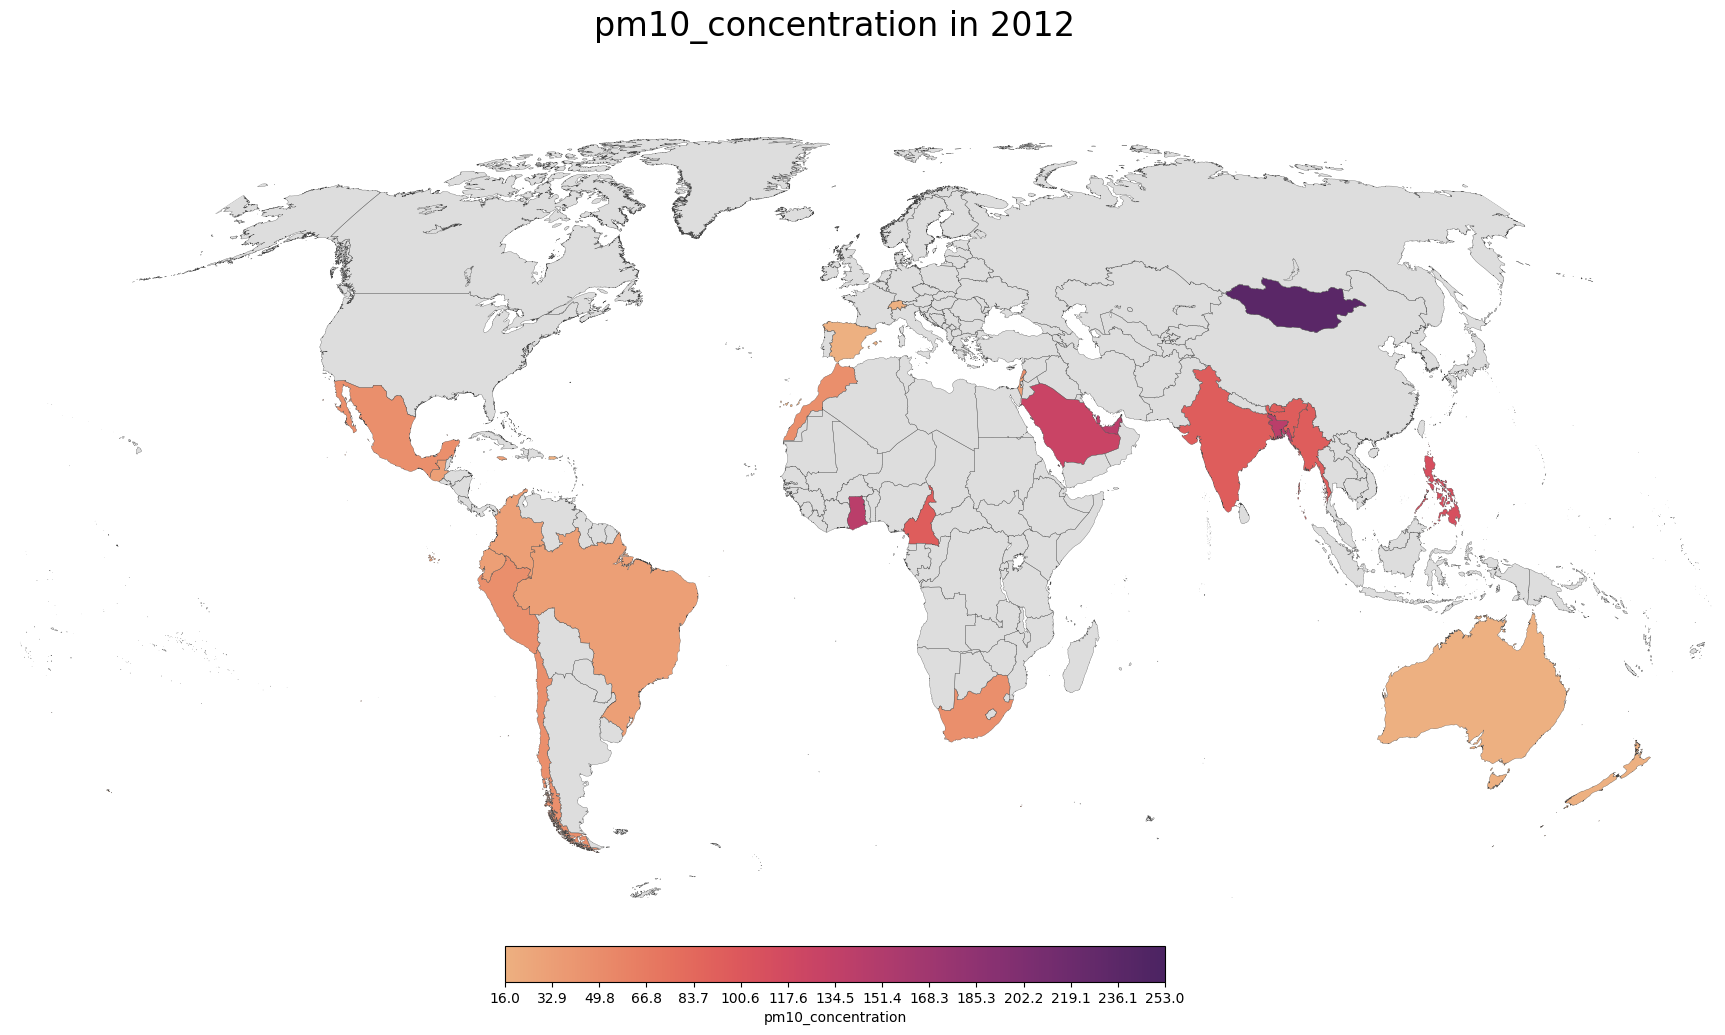

In [ ]:
create_color_map('pm10_concentration', 2015, merged_df)

### 1.2.3 Correlation of Feature Variables
Here, we are looking to create a correlation matrix of feature variables. Examining the relationship between features is crucial because some models, such as Linear Regression, may not perform effectively in the presence of significant multicollinearity.

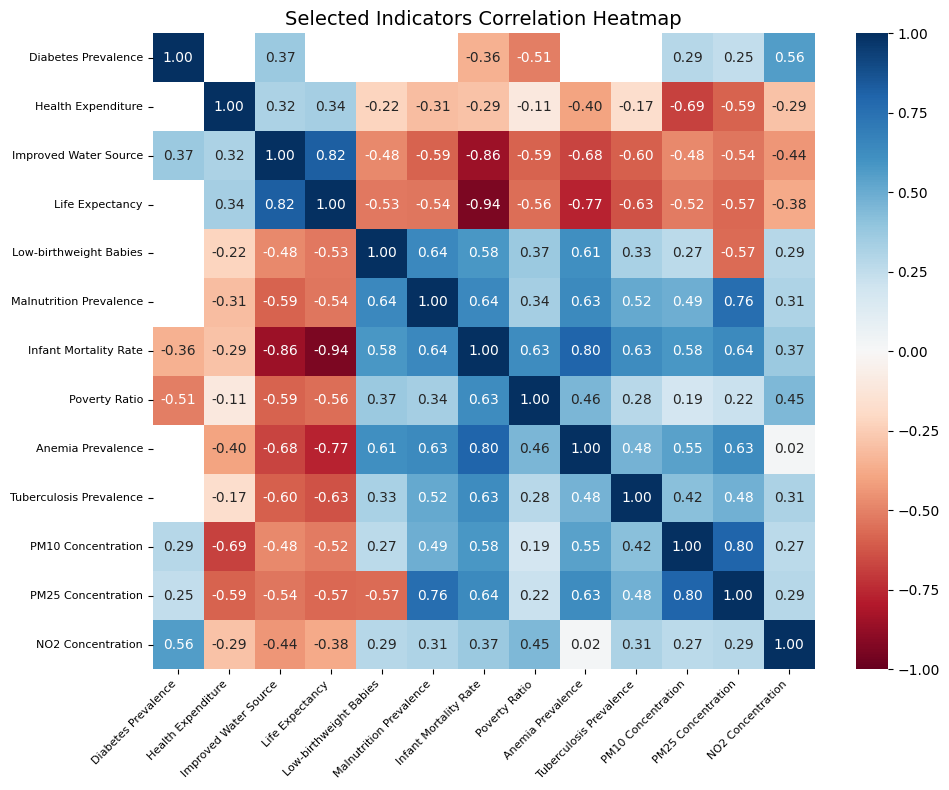

In [ ]:
# Plotting correlation heatmaps for merged_df
df_corr = merged_df.drop(columns=['Country Name','Country Code','Year'])
corr_mat = df_corr.corr()

plt.figure(figsize=(10, 8))

# Create the heatmap with custom x and y tick labels
heatmap = sns.heatmap(corr_mat, cmap='RdBu', center=0, annot=True, fmt=".2f", vmin=-1, vmax=1)

# Setting the title
plt.title('Selected Indicators Correlation Heatmap', fontsize=14)

# Relabeling x-axis ticks for clarity
xticklabels = ['Diabetes Prevalence', 'Health Expenditure', 'Improved Water Source',
               'Life Expectancy', 'Low-birthweight Babies', 'Malnutrition Prevalence',
               'Infant Mortality Rate', 'Poverty Ratio', 'Anemia Prevalence',
               'Tuberculosis Prevalence', 'PM10 Concentration', 'PM25 Concentration',
               'NO2 Concentration']
heatmap.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)

# Relabeling y-axis ticks for clarity
yticklabels = ['Diabetes Prevalence', 'Health Expenditure', 'Improved Water Source',
               'Life Expectancy', 'Low-birthweight Babies', 'Malnutrition Prevalence',
               'Infant Mortality Rate', 'Poverty Ratio', 'Anemia Prevalence',
               'Tuberculosis Prevalence', 'PM10 Concentration', 'PM25 Concentration',
               'NO2 Concentration']
heatmap.set_yticklabels(yticklabels, rotation=0, fontsize=8)

plt.tight_layout()
plt.show()

# Part II: Modeling

When choosing indicators, we wanted to choose factors that could present different levels of correlation, based on our prior knowledge and best guesses of air pollution.

**Prevalence of Tuberculosis (High Correlation)**

Tuberculosis (TB) is primarily a respiratory disease that primarily affects the lungs, though it can impact other parts of the body. Given that air pollutants, particularly particulate matter and nitrogen dioxide, can aggravate respiratory conditions and impair lung function, it is logical to expect a higher correlation with the prevalence of tuberculosis. Polluted air can exacerbate the symptoms of TB and increase susceptibility to contracting the disease, especially in areas with poor air quality.

**Infant Mortality Rate (Medium Correlation)**

Infant mortality rate is chosen as a target with medium correlation because while air quality can significantly impact infant health through respiratory issues, low birth weight, and developmental problems, there are also many other factors at play that can influence infant mortality rates. These include genetic factors, maternal health, access to medical care, and socio-economic conditions. Thus, while there is an expected correlation due to the direct impact of air quality on respiratory health and developmental issues in infants, the presence of multiple influencing factors might dilute the strength of this correlation.

**Anemia in Pregnant Women (Low Correlation)**

Anemia in pregnant women is primarily influenced by nutritional intake and medical conditions such as iron deficiency or internal parasitic diseases, rather than direct exposure to air pollution. While there may be indirect pathways through which poor air quality could contribute to anemia, such as through increased health burden from respiratory diseases, the correlation between air pollutants and anemia in pregnant women is expected to be lower compared to more direct health impacts. Therefore, this indicator serves as a potentially low-correlation target to explore the broader and less direct effects of air pollution on public health.

By selecting these indicators, the study aims to cover a spectrum of potential impacts, from highly direct to more tangential, providing a comprehensive view of how air quality affects different aspects of public health. This approach not only helps in understanding the varied effects of pollution but also in illustrating the complexity of environmental influences on health.

## 2.1 K-Means Clustering

Before running supervised learning methods, we wanted to use K-Means clustering to see how countries compared based on the features we would be using in our models. Due to the large number of NULL datapoints, we will be using a subset of features used in other models.

In [ ]:
# Select list of features for KMeans
kmeans_fields = ["Country Code",
"Year",
"Health expenditure, total (% of GDP)",
'Improved water source (% of population with access)',
"Mortality rate, infant (per 1,000 live births)",
"Prevalence of tuberculosis (per 100,000 population)",
"pm10_concentration",
"no2_concentration"]

In [ ]:
merged_df.isnull().sum()

Country Name                                                              0
Country Code                                                              0
Year                                                                      0
Diabetes prevalence (% of population ages 20 to 79)                    9244
Health expenditure, total (% of GDP)                                   3345
Improved water source (% of population with access)                      13
Life expectancy at birth, total (years)                                3338
Low-birthweight babies (% of births)                                  11735
Malnutrition prevalence, weight for age (% of children under 5)       12371
Mortality rate, infant (per 1,000 live births)                           13
Poverty headcount ratio at national poverty line (% of population)    11075
Prevalence of anemia among pregnant women (%)                          9944
Prevalence of tuberculosis (per 100,000 population)                    3335
pm10_concent

We select the fields we want to use for Kmeans from the prior dataframe. When we look at the nulls, we can see how many rows will be impacted by missing data.

In [ ]:
kmeans_df = merged_df[kmeans_fields]
print(kmeans_df.isnull().sum())

Country Code                                              0
Year                                                      0
Health expenditure, total (% of GDP)                   3345
Improved water source (% of population with access)      13
Mortality rate, infant (per 1,000 live births)           13
Prevalence of tuberculosis (per 100,000 population)    3335
pm10_concentration                                     2617
no2_concentration                                      3867
dtype: int64


We drop the nulls from the dataframe. Notice how many countries are dropped from the analysis as a result.

In [ ]:
kmeans_df = kmeans_df.dropna()
print(kmeans_df['Country Code'].nunique())

49


Here we select the features for the model.

In [ ]:
feature_fields = ["Health expenditure, total (% of GDP)",
"Mortality rate, infant (per 1,000 live births)",
"Prevalence of tuberculosis (per 100,000 population)",
"pm10_concentration",
"no2_concentration"]

features = kmeans_df[feature_fields]

Now we want to scale the data using StandardScaler.

In [ ]:
# Scale data for model input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Next, we will plot WCSS while iterating over the num_clusters hyperparameter to see which value we should use.

In [ ]:
# for k ranges from 2 to 10, fit on "features" to generate an elbow plot
num_clusters = [x for x in range(2, 11)]

WCSS = []

for k in num_clusters:
  kmeans = KMeans(n_clusters = k, n_init = 5, random_state = 0)
  kmeans.fit(features_scaled)
  WCSS.append(kmeans.inertia_)

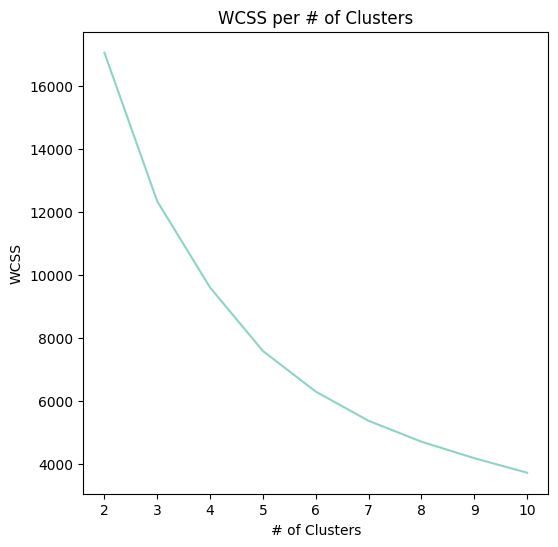

In [ ]:
# Elbow plot to find best number of clusters
plt.figure(figsize=(6, 6))

plt.plot(num_clusters, WCSS)

plt.xlabel('# of Clusters')
plt.ylabel('WCSS')
plt.title('WCSS per # of Clusters')

plt.show()

Using the elbow method, it seems that 7 clusters will be best to use.

In [ ]:
# Choose the best number of clusters (the elbow) for kmeans
number_of_cluster = 7

Now we re-fit the model using the best number of clusters.

In [ ]:
# Re-run the K-Means clustering with the best number of clusters, save the fitted model to `kmeans`
kmeans = KMeans(n_clusters = number_of_cluster, n_init = 5, random_state = 0)
kmeans.fit(features_scaled)

KMeans(n_clusters=7, n_init=5, random_state=0)

We now append the predicted clusters to each corresponding entry in the dataframe.

In [ ]:
# Get predicted cluster for each country and append to df
clusters = kmeans.predict(features_scaled)
kmeans_df["Cluster"] = clusters

Since we have multiple years of data, we are going to group by country on the aggregation of the mode of clusters. Since some countries may have multiple modes over several years, we will take the first mode listed.

In [ ]:
# Create DF of country and the corresponding mode of clusters
# If country has multiple modes, get the first
country_cluster_df = kmeans_df.groupby('Country Code')['Cluster'].agg(lambda x: x.mode()[0]).reset_index()

Now we will make a map of countries and their clusters using GeonamesCache.

<ipython-input-218-2273c5712fbe>:37: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = [Polygon(np.array(shape), True)]


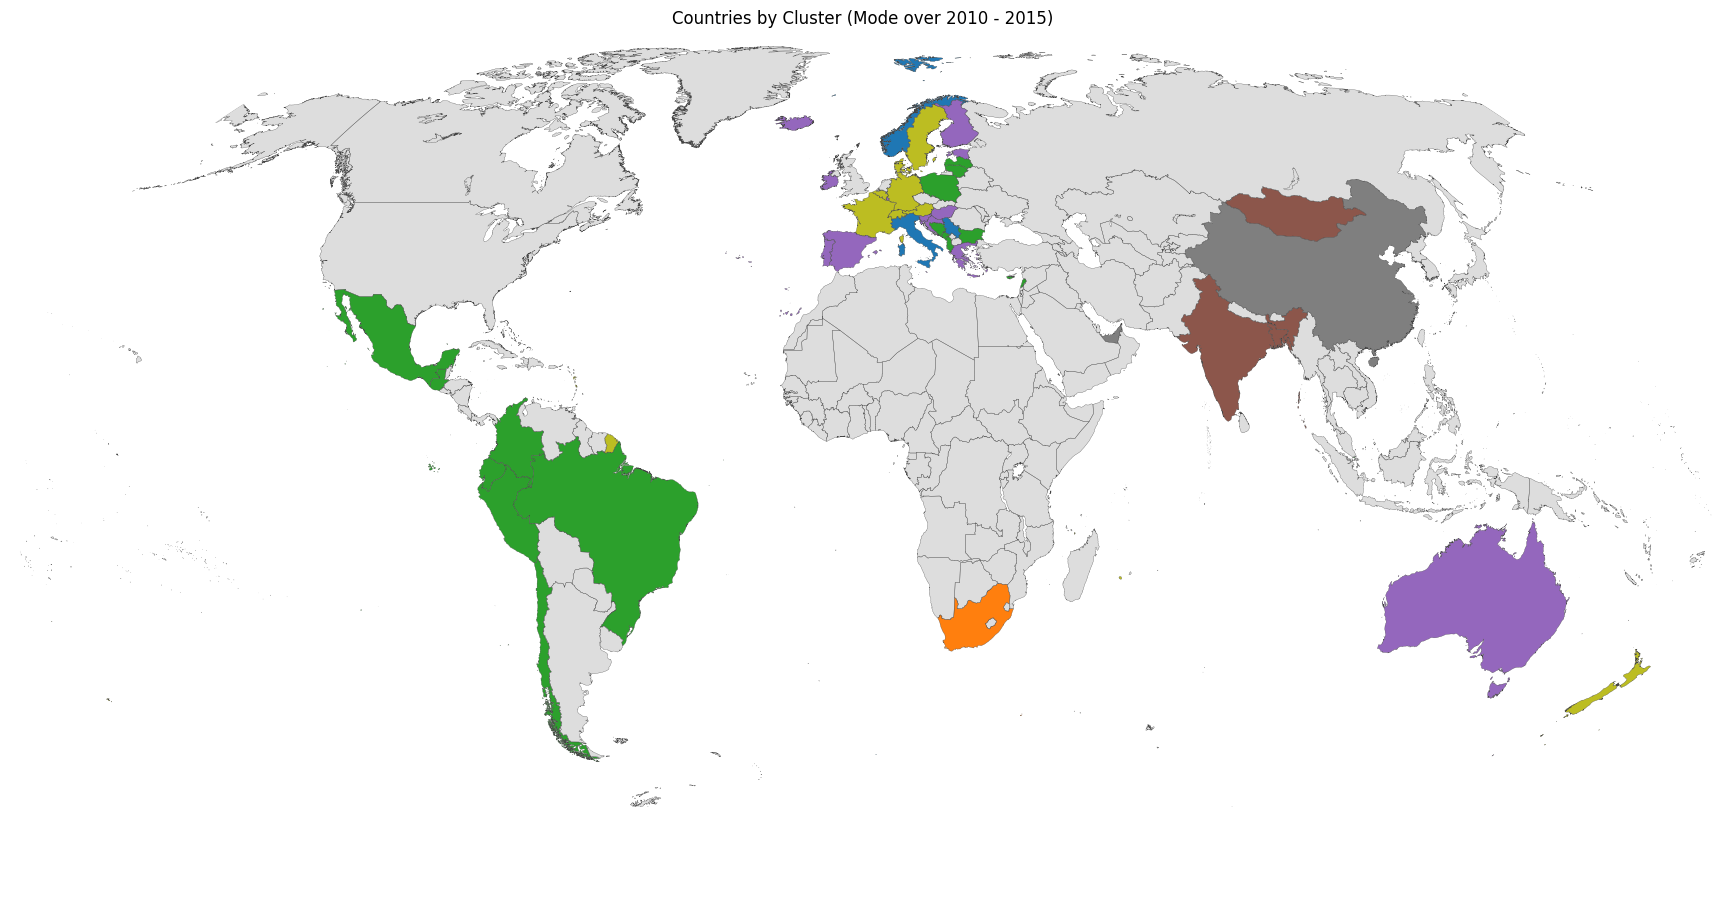

In [ ]:
def create_cluster_map(feature, df_map):

    # 1 - INPUTS
    shapefile=('ne_10m_admin_0_countries_lakes')
    num_colors = (df_map[feature].nunique())
    cols = ['Country Code', feature]

    # 2 - FILTER COUNTRIES AND GENERATE COLORS

    # Filter countries with country code in GeonamesCache
    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

    # Create DataFrame
    df_map = df_map.loc[df_map['Country Code'].isin(iso3_codes)].dropna()

    # Generate color bins based on feature
    values = df_map[feature]
    cm = plt.get_cmap('tab10')
    scheme = [cm(i / num_colors) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    df_map['bin'] = np.digitize(values, bins) - 1

    # 3 - GENERATE MAP
    fig = plt.figure(figsize=(22, 12))
    ax = fig.add_subplot(111, facecolor='w', frame_on=False)
    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')
    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)

    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in list(df_map['Country Code']):
            color = '#dddddd'
        else:
            color = scheme[df_map.loc[df_map['Country Code']==iso3, 'bin'].values[0]]
        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])

    plt.title("Countries by Cluster (Mode over 2010 - 2015)")
    plt.show()

create_cluster_map('Cluster', country_cluster_df)

The clusters seem to be formed consistently between geographical and socioeconomic regions. Europe has the most splits with a divide between Central Europe and the surrounding regions. Eastern Europe is more closely aligned with Latin America which is largely a single group. South Africa is in it's own group whereas Asia sees a divide between China and it's neighbors. Australia and New Zealand fall within the same clusters as Europe.

It is interesting to see the BRICS nations (Brazil, India, China, and South Africa) all fall within different clusters. Unfortunately, because of the NULL rows, there were far fewer countries that we were able to cluster when compared to the mortality map in Part 1. It would be interesting to see how these clusters would differ if we had the data for more countries.


## 2.2 Random Forest Classifier

This Random Forest Classifier is designed to predict life expectancy quartiles based on selected socio-economic and health-related indicators. The chosen indicators—health expenditure per capita, access to improved water sources, and poverty headcount ratios—provide a multifaceted view of the factors that may influence a population's life expectancy at birth.

The dataset was carefully prepared by filtering for relevant indicators and transforming the life expectancy into quartiles, which serves as the categorical target variable. This transformation allows the model to classify life expectancy into more granular categories, thereby facilitating a nuanced analysis of the impact of health expenditure and socio-economic conditions on life expectancy. Feature engineering techniques, including the creation of interaction terms and polynomial features based on health expenditure, were employed to capture non-linear effects and potential synergies between time and expenditure.

The Random Forest model was trained using a GridSearchCV approach to optimize hyperparameters such as the number of estimators, maximum depth, and minimum samples split. This optimization is crucial for enhancing model accuracy and preventing overfitting. The model's performance was rigorously evaluated using a standard train-test split, with results indicating effective predictive capabilities, as evidenced by high accuracy scores and detailed classification metrics provided in the classification report.

The decision trees within the Random Forest were visualized to offer insights into the decision-making processes of the model. These visualizations underscore the importance of the selected features and provide transparency into how different thresholds and combinations of features influence the prediction of life expectancy quartiles.

The Random Forest Classifier suggests that the integration of health-related expenditures with key socio-economic indicators can significantly enhance the predictive modeling of life expectancy. This approach not only aids in the understanding of the complex interplay between health services accessibility and socio-economic factors but also provides actionable insights that can inform public health policy and resource allocation.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap

# Convert 'Life expectancy at birth, total (years)' into quartiles for classification
merged_df['Life Expectancy Quartiles'] = pd.qcut(merged_df['Life expectancy at birth, total (years)'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Feature selection
features = ['Health expenditure, total (% of GDP)', 'Improved water source (% of population with access)', 'Poverty headcount ratio at national poverty line (% of population)']
X = merged_df[features]
y = merged_df['Life Expectancy Quartiles']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning with GridSearchCV to prevent overfitting
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
rf_classifier = RandomForestClassifier(**grid_search.best_params_, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Predictions and classification report
y_pred = rf_classifier.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

          Q1       1.00      0.98      0.99       103
          Q2       0.97      1.00      0.99       113
          Q3       1.00      0.99      1.00       114
          Q4       1.00      1.00      1.00       118

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



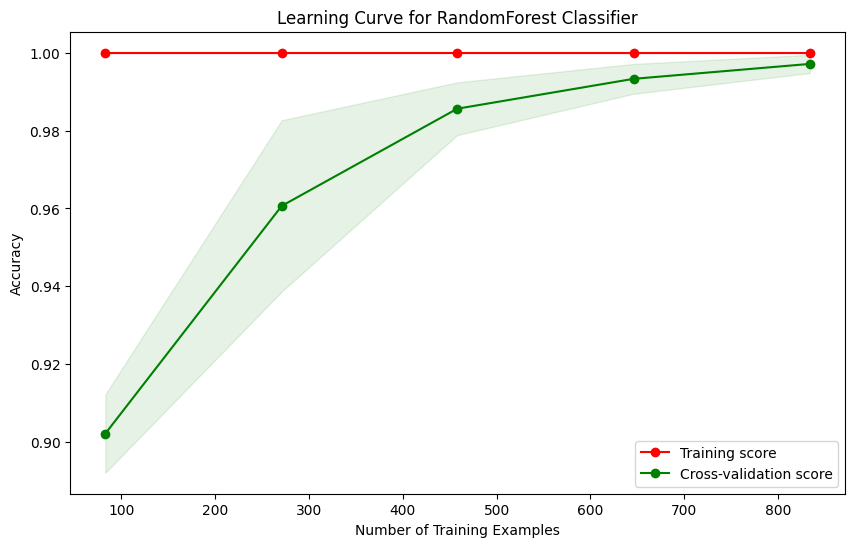

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Reset default matplotlib settings
plt.rcdefaults()

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X_train_scaled, y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5, scoring='accuracy', n_jobs=-1
)

# Calculate means and standard deviations for train and test sets
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

# Fill areas between the mean and standard deviation
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

# Adding labels and title
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve for RandomForest Classifier')
plt.legend(loc='lower right')
plt.show()


The learning curve depicted illustrates the performance of our RandomForest classifier as the number of training examples increases. The x-axis represents the number of training examples, while the y-axis denotes the accuracy of the model. The red line corresponds to the training score, which remains consistently high across the number of training examples, indicating that the classifier is capable of accurately modeling the training data.

The green line represents the cross-validation score. Initially, there is a noticeable difference between the training and cross-validation scores, suggesting some overfitting when the number of training examples is small. However, as more training data are introduced, the cross-validation score improves significantly and starts to converge towards the training score, albeit with a slight gap remaining. This indicates that adding more data helps the model generalize better and reduces overfitting.

The shaded areas around the lines indicate the standard deviation at each point, offering a glimpse into the variability of the model's performance. The narrowing of the shaded area around the cross-validation score as the number of training examples increases demonstrates reduced variance in the model's predictions, further emphasizing improved model stability and reliability with additional data.

From the plot, we can infer that the model's ability to generalize improves with more data, which is typical as additional data provides a more comprehensive representation of the underlying problem space. The high training score and the convergence trend suggest that the RandomForest classifier is appropriately complex for the task. Given the high accuracy and the shape of the learning curve, further improvements in model performance may be limited without additional feature engineering, implementing more advanced models, or gathering more diverse training samples. The remaining gap between the training and cross-validation scores offers a small but valuable opportunity for further optimization, potentially through hyperparameter tuning or exploring alternative modeling techniques that might be less prone to overfitting.

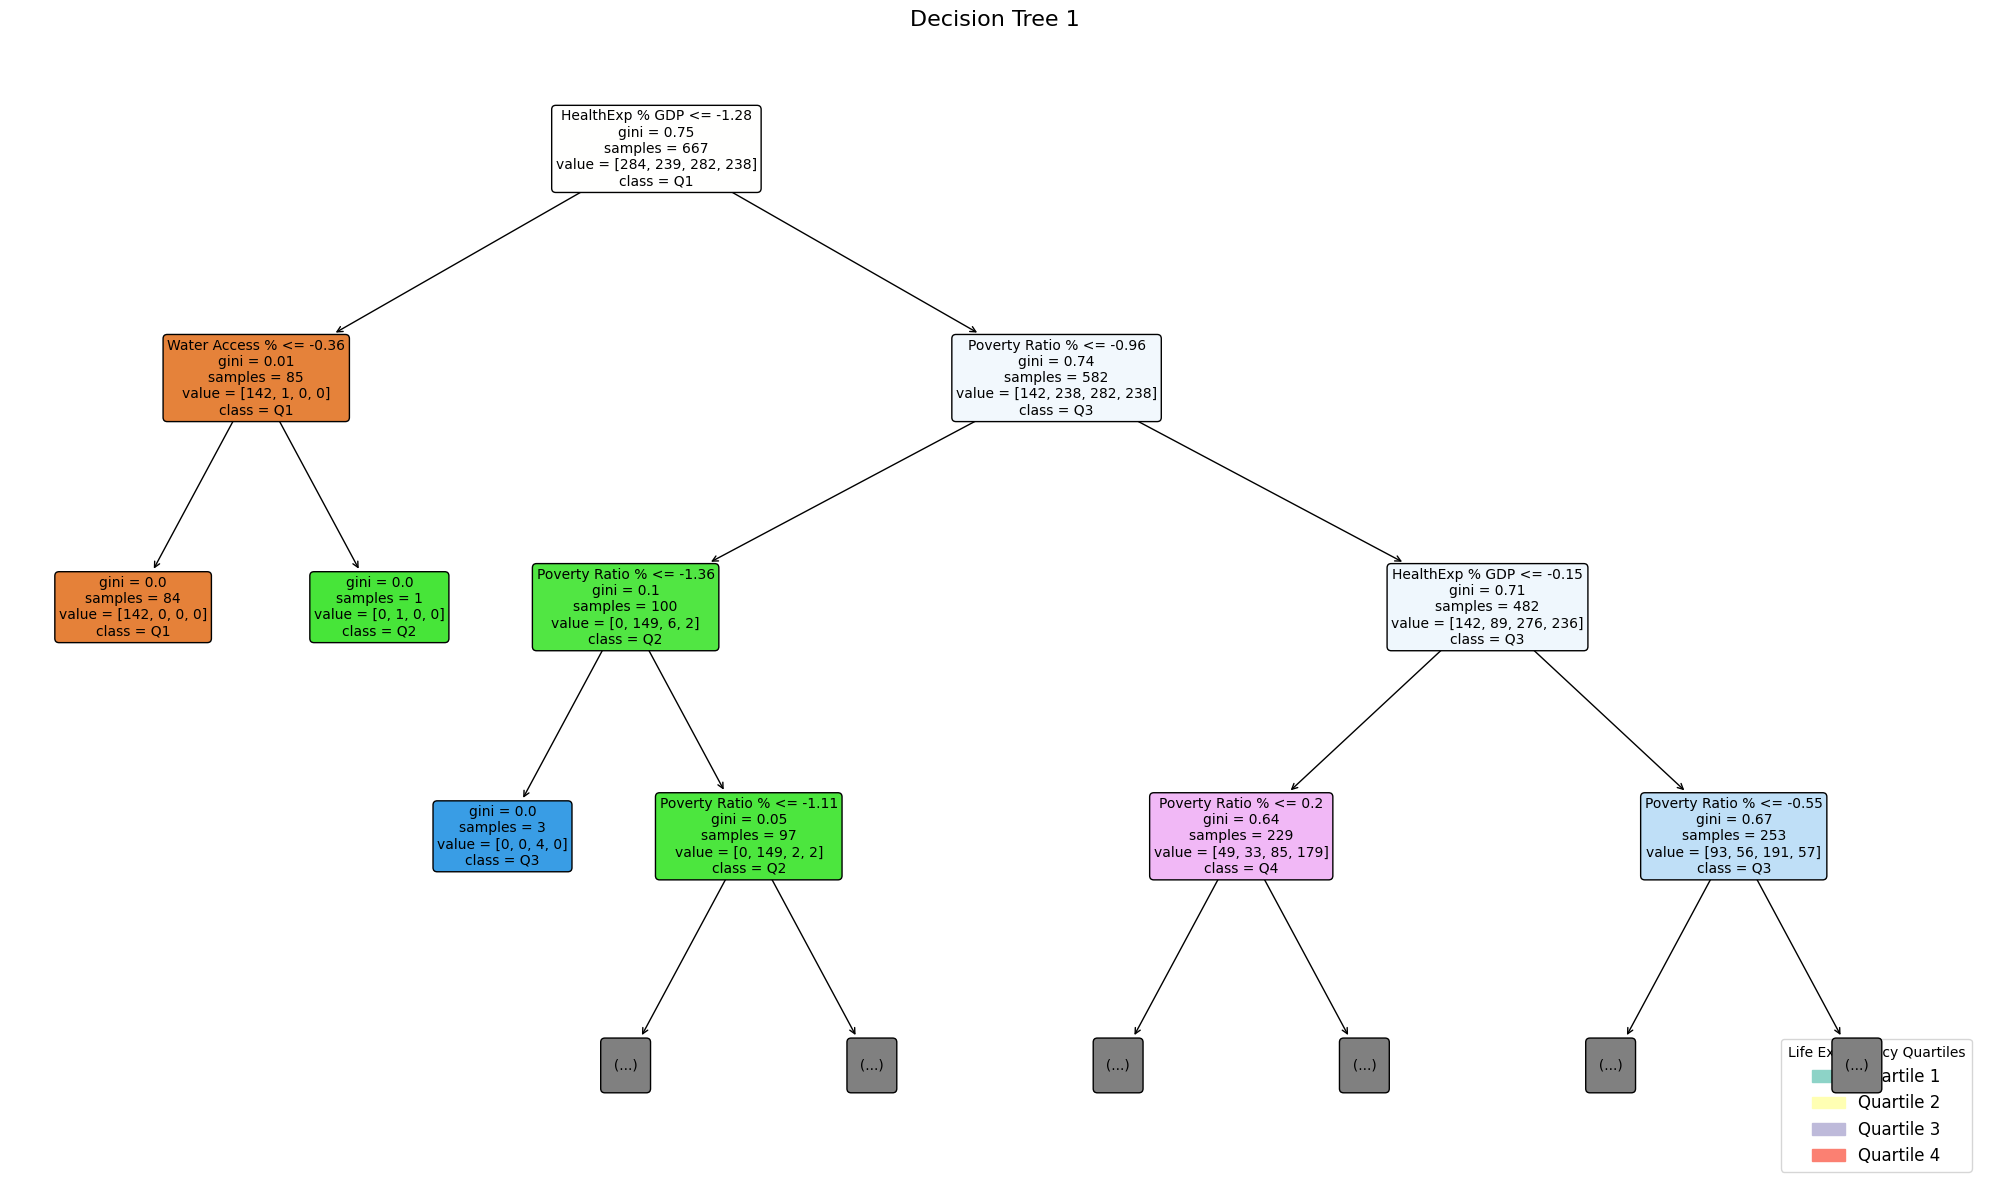

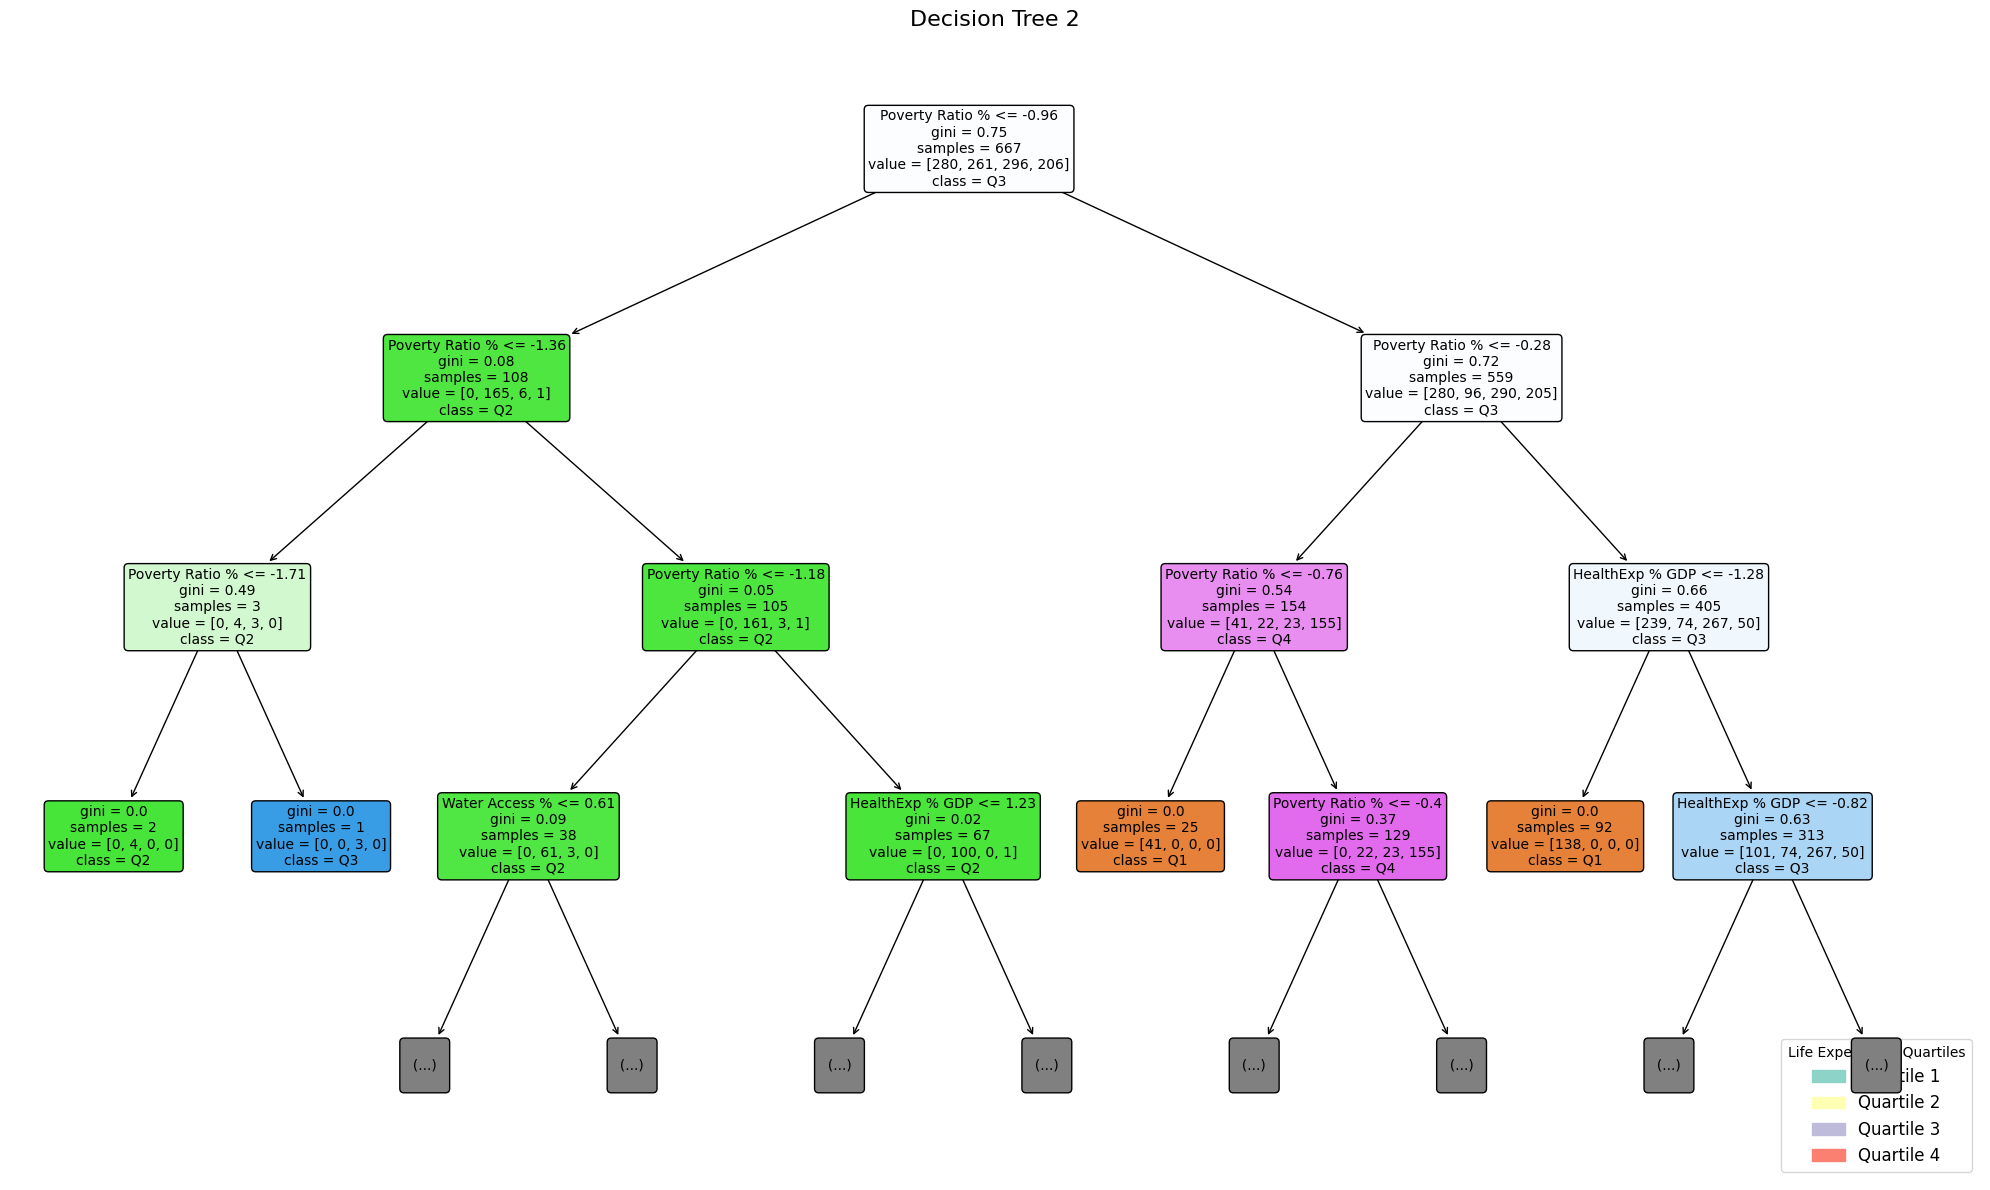

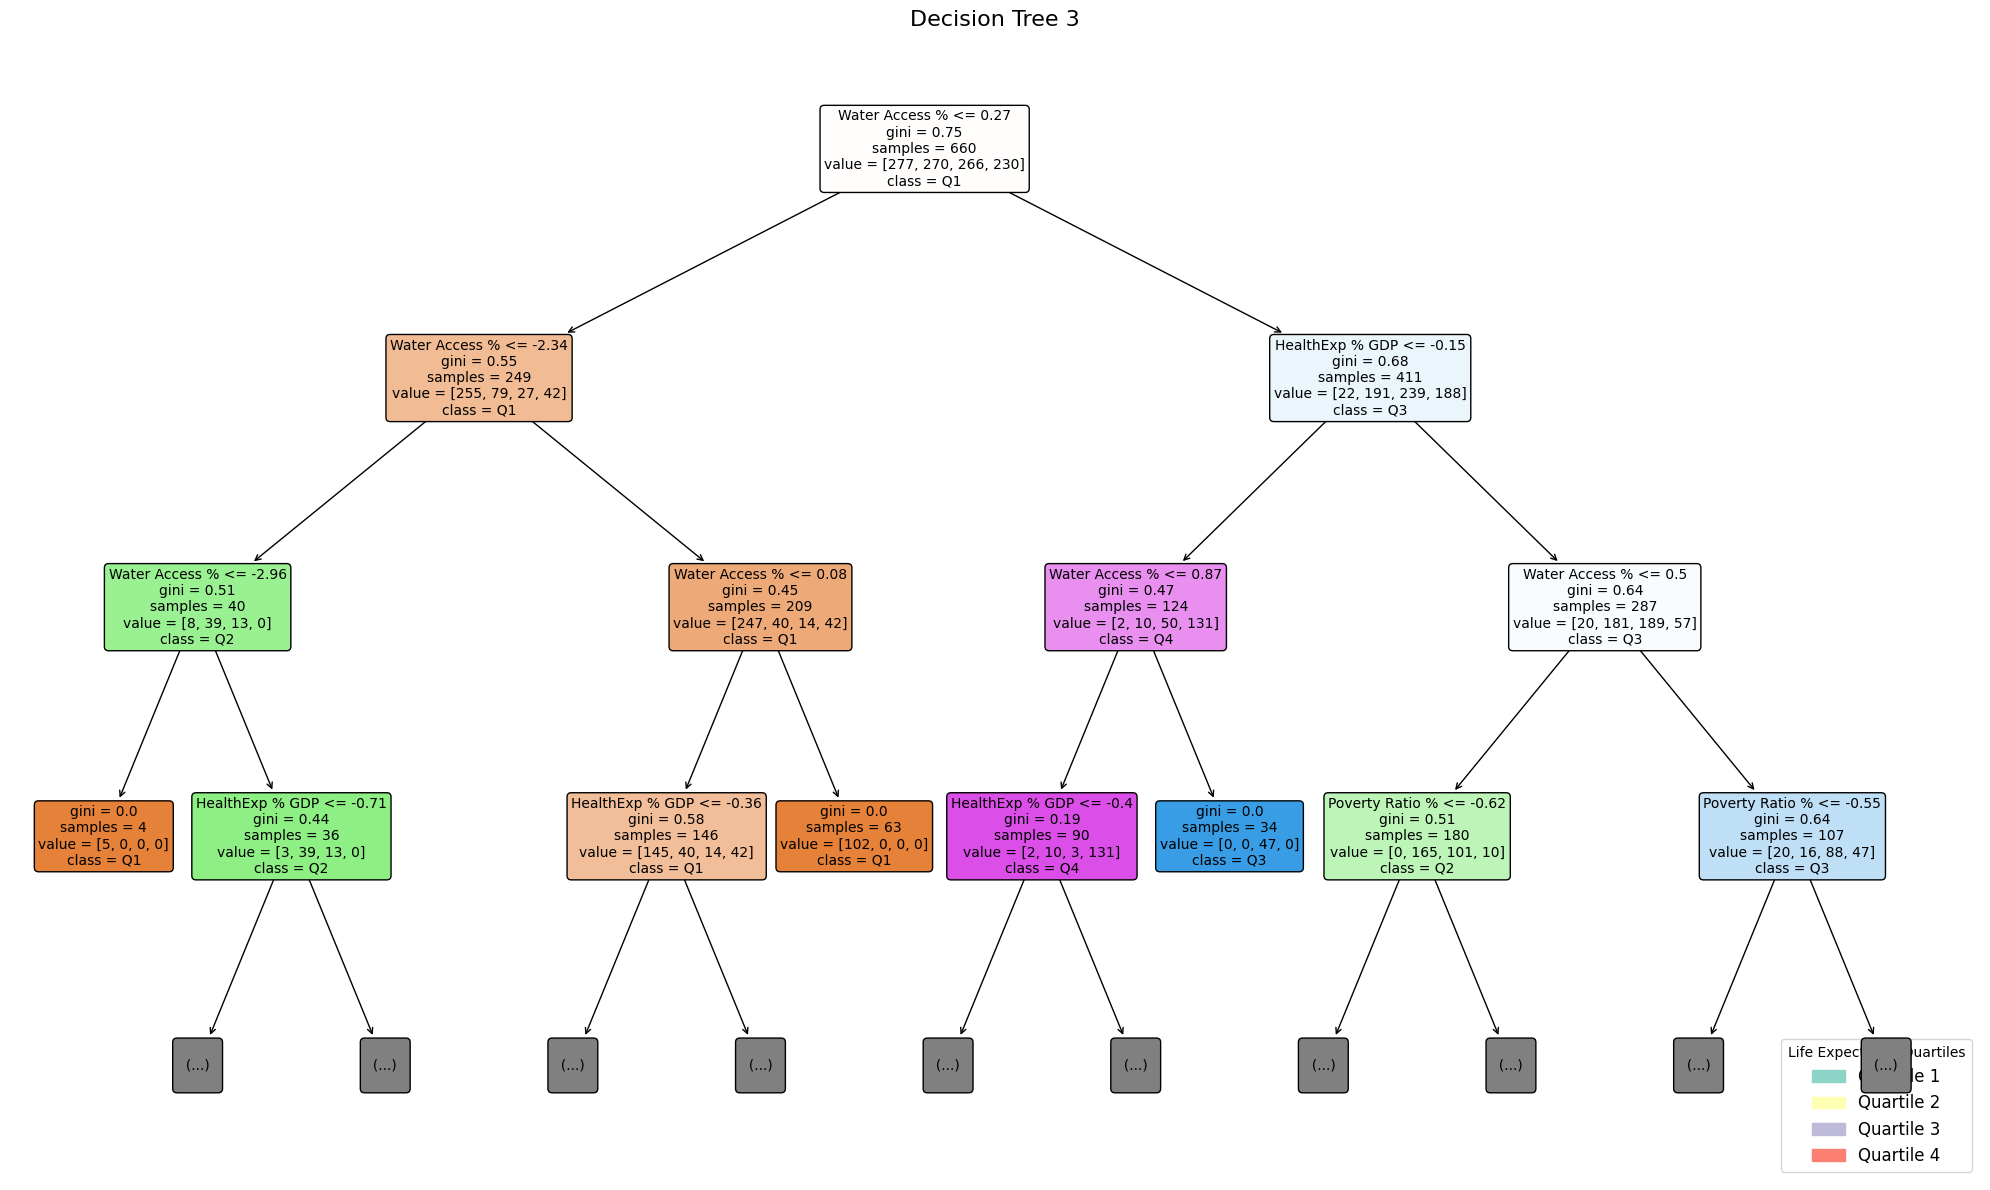

In [ ]:
# Visualization settings
colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072']
cmap = ListedColormap(colors)
plt.rcParams['image.cmap'] = cmap
patches = [mpatches.Patch(color=colors[i], label=f'Quartile {i+1}') for i in range(4)]

# Visualization of decision trees
num_trees_to_visualize = 3
trees = rf_classifier.estimators_[:num_trees_to_visualize]

for idx, tree in enumerate(trees):
    plt.figure(figsize=(20, 12))
    plot_tree(tree, feature_names=X.columns, class_names=['Q1', 'Q2', 'Q3', 'Q4'], filled=True, rounded=True,
              proportion=False, precision=2, max_depth=3, fontsize=10)
    plt.title(f'Decision Tree {idx + 1}', fontsize=16)
    plt.legend(handles=patches, frameon=True, title='Life Expectancy Quartiles', fontsize=12, loc='lower right')
    plt.tight_layout()
    plt.show()

The decision trees presented demonstrate the process by which the RandomForest classifier has been trained to categorize data into four distinct quartiles of life expectancy, as determined by the training data's underlying distribution. Each tree is part of an ensemble that collectively makes the final classification decision, with each individual tree contributing to the robustness and generalizability of the model.

Within these decision trees, the splits are determined by the features: 'HealthExp % GDP', 'Water Access %', and 'Poverty Ratio %'. The branching logic indicates that the model has identified 'Water Access %' as a primary determinant of life expectancy, often appearing as the root node. This reflects the importance of clean water access in predicting life expectancy across the dataset.

The nodes' color coding corresponds to the majority life expectancy quartile among the samples at that node, utilizing a color palette defined in the code for visual clarity. The terminal nodes (leaves) indicate the quartile classification with the lowest Gini impurity within the training data subset reaching that point. The Gini impurity measure is indicative of the homogeneity of the samples within each node; a lower Gini impurity represents higher homogeneity. In some cases, the Gini impurity is zero, signifying that all samples at that node belong to the same quartile, hence the perfect classification at that branch.

Each node details the threshold value for the split based on the feature, the Gini impurity, the number of samples, and the distribution of the samples across the quartiles ('value'). In the decision-making process, we observe that different features take precedence at different levels of the trees, illustrating the non-linear and hierarchical nature of the decision-making process inherent to decision tree models.

The trees provide insights into feature importance and decision logic. However, the visualization is complex, with nodes and leaves densely packed at each level, making it challenging to interpret without zooming into individual branches. For further analysis, one could prune the tree to focus on higher-level splits or utilize tree interpretation tools for a clearer view of the decision paths most relevant to classification.

The ensemble of these decision trees, each contributing unique decision paths to the final model, exemplifies the strength of the RandomForest approach, where the aggregation of multiple models aims to reduce overfitting and improve predictive performance on unseen data.

## 2.3 Regression

In [ ]:
df_pop_health.dtypes.head(10)

Country Name       object
Country Code       object
Indicator Name     object
Indicator Code     object
1960              float64
1961              float64
1962              float64
1963              float64
1964              float64
1965              float64
dtype: object

In [ ]:
df_pop_health_long = pd.melt(df_pop_health,
                             id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                             var_name='year',
                             value_name='value')
df_pop_health_long['year'] = df_pop_health_long['year'].astype(int)
# df_pop_health_long.head()
df_merged = pd.merge(df_pop_health_long, df_air_quality,
                     left_on=['Country Name', 'year'],
                     right_on=['country_name', 'year'])

In [ ]:
print(df_merged.shape)

(4339410, 10)


In [ ]:
df_merged.head()

,Country Name,Country Code,Indicator Name,Indicator Code,year,value,country_name,pm10_concentration,pm25_concentration,no2_concentration
0,Australia,AUS,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,2010,NaN,Australia,15.9,NaN,NaN
1,Australia,AUS,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,2010,NaN,Australia,17.6,9.2,NaN
2,Australia,AUS,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,2010,NaN,Australia,NaN,8.5,NaN
3,Australia,AUS,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,2010,NaN,Australia,22.8,NaN,NaN
4,Australia,AUS,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,2010,NaN,Australia,21.7,NaN,NaN


In [ ]:
print(df_merged.isnull().sum())

Country Name                0
Country Code                0
Indicator Name              0
Indicator Code              0
year                        0
value                 1463903
country_name                0
pm10_concentration     902865
pm25_concentration    2676855
no2_concentration     1334115
dtype: int64


In [ ]:
df_merged_cleaned = merged_df.dropna(subset=['pm10_concentration', 'pm25_concentration', 'no2_concentration'])
print(df_merged_cleaned.isnull().sum())
print(df_merged_cleaned.shape)
df_merged_cleaned_2 = df_merged.dropna(subset=['pm10_concentration', 'pm25_concentration', 'no2_concentration','value'])
print(df_merged_cleaned_2.isnull().sum())
print(df_merged_cleaned_2.shape)
df_merged_cleaned_2.head()

Country Name                                                          339
Country Code                                                          339
Year                                                                    0
Diabetes prevalence (% of population ages 20 to 79)                   477
Health expenditure, total (% of GDP)                                  384
Improved water source (% of population with access)                   339
Life expectancy at birth, total (years)                               384
Low-birthweight babies (% of births)                                  512
Malnutrition prevalence, weight for age (% of children under 5)       511
Mortality rate, infant (per 1,000 live births)                        339
Poverty headcount ratio at national poverty line (% of population)    473
Prevalence of anemia among pregnant women (%)                         478
Prevalence of tuberculosis (per 100,000 population)                   384
pm10_concentration                    

,Country Name,Country Code,Indicator Name,Indicator Code,year,value,country_name,pm10_concentration,pm25_concentration,no2_concentration
2662,Austria,AUT,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,2010,9.5894,Austria,14.546,10.911,7.374
2666,Austria,AUT,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,2010,9.5894,Austria,30.651,21.925,34.976
2679,Austria,AUT,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,2010,9.5894,Austria,23.601,19.169,10.800
2681,Austria,AUT,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,2010,9.5894,Austria,22.831,16.114,28.560
2686,Austria,AUT,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,2010,9.5894,Austria,24.870,18.123,37.724


Indicator = 'Prevalence of tuberculosis (per 100,000 population)'

In [ ]:
# Filter dataset for desired inidicators

df_infant_mortality = merged_df[['Country Name','Year','Mortality rate, infant (per 1,000 live births)','pm10_concentration', 'pm25_concentration', 'no2_concentration']]
df_anemia_pregnant = merged_df[['Country Name','Year','Prevalence of anemia among pregnant women (%)','pm10_concentration', 'pm25_concentration', 'no2_concentration']]
df_tuberculosis = merged_df[['Country Name','Year','Prevalence of tuberculosis (per 100,000 population)','pm10_concentration', 'pm25_concentration', 'no2_concentration']]

# Set up predictor and target variables
df_infant_mortality.dropna(subset=['Country Name','Mortality rate, infant (per 1,000 live births)','pm10_concentration', 'pm25_concentration', 'no2_concentration'],inplace=True)
X_infant_mortality = df_infant_mortality[['pm10_concentration', 'pm25_concentration', 'no2_concentration']]
y_infant_mortality = df_infant_mortality['Mortality rate, infant (per 1,000 live births)']

df_anemia_pregnant.dropna(subset=['Country Name','Prevalence of anemia among pregnant women (%)','pm10_concentration', 'pm25_concentration', 'no2_concentration'],inplace=True)
X_anemia_pregnant = df_anemia_pregnant[['pm10_concentration', 'pm25_concentration', 'no2_concentration']]
y_anemia_pregnant = df_anemia_pregnant['Prevalence of anemia among pregnant women (%)']

df_tuberculosis.dropna(subset=['Country Name','Prevalence of tuberculosis (per 100,000 population)','pm10_concentration', 'pm25_concentration', 'no2_concentration'],inplace=True)
X_tuberculosis = df_tuberculosis[['pm10_concentration', 'pm25_concentration', 'no2_concentration']]
y_tuberculosis = df_tuberculosis['Prevalence of tuberculosis (per 100,000 population)']

<ipython-input-47-38543dba49d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_infant_mortality.dropna(subset=['Country Name','Mortality rate, infant (per 1,000 live births)','pm10_concentration', 'pm25_concentration', 'no2_concentration'],inplace=True)
<ipython-input-47-38543dba49d6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anemia_pregnant.dropna(subset=['Country Name','Prevalence of anemia among pregnant women (%)','pm10_concentration', 'pm25_concentration', 'no2_concentration'],inplace=True)
<ipython-input-47-38543dba49d6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [ ]:
df_infant_mortality.head()

,Country Name,Year,"Mortality rate, infant (per 1,000 live births)",pm10_concentration,pm25_concentration,no2_concentration
110,Albania,2014,12.9,28.181800,12.910750,22.387800
111,Albania,2015,12.5,25.467500,16.355750,18.094000
608,Australia,2012,3.6,18.714500,11.833333,3.502500
609,Australia,2013,3.4,18.531619,7.838235,12.398500
610,Australia,2014,3.2,17.740172,7.368524,11.432111
...,...,...,...,...,...,...
12115,Switzerland,2012,3.7,17.846815,12.733333,24.236648
12116,Switzerland,2013,3.6,17.935545,13.666667,24.013237
12117,Switzerland,2014,3.5,14.949625,8.977778,23.292047
12118,Switzerland,2015,3.4,16.553866,11.234222,23.693966


### 2.3.1 Linear Regression

In order to establish a relationship between air pollutants and health indicators, we chose to use a Linear Regression model. We selected PM10 as the main concentration to look at it due to it containing the least amount of nulls in our dataset. The goal is to generate a predictive model for each health indicator and evaluate the model using metrics like the Mean Squared Error and R-squared value in an effort to help us understand how much variance in health outcomes can be explained by pollutants.


In [ ]:
# Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split data, train models and evaluate for Infant Mortality
X_train_im, X_test_im, y_train_im, y_test_im = train_test_split(X_infant_mortality, y_infant_mortality, test_size=0.2, random_state=42)
model_im = LinearRegression()
model_im.fit(X_train_im, y_train_im)
y_pred_im = model_im.predict(X_test_im)
mse_im = mean_squared_error(y_test_im, y_pred_im)
r2_im = r2_score(y_test_im, y_pred_im)

In [ ]:
# Split data, train models and evaluate for Anemia in Pregnant Women
X_train_ap, X_test_ap, y_train_ap, y_test_ap = train_test_split(X_anemia_pregnant, y_anemia_pregnant, test_size=0.2, random_state=42)
model_ap = LinearRegression()
model_ap.fit(X_train_ap, y_train_ap)
y_pred_ap = model_ap.predict(X_test_ap)
mse_ap = mean_squared_error(y_test_ap, y_pred_ap)
r2_ap = r2_score(y_test_ap, y_pred_ap)

In [ ]:
# Split data, train models and evaluate for Tuberculosis
X_train_tb, X_test_tb, y_train_tb, y_test_tb = train_test_split(X_tuberculosis, y_tuberculosis, test_size=0.2, random_state=42)
model_tb = LinearRegression()
model_tb.fit(X_train_tb, y_train_tb)
y_pred_tb = model_tb.predict(X_test_tb)
mse_tb = mean_squared_error(y_test_tb, y_pred_tb)
r2_tb = r2_score(y_test_tb, y_pred_tb)

In [ ]:
print(f'Infant Mortality Model - MSE: {mse_im}, R^2: {r2_im}')
print(f'Anemia in Pregnant Women Model - MSE: {mse_ap}, R^2: {r2_ap}')
print(f'Prevalance of Tuberculosis - MSE: {mse_tb}, R^2: {r2_tb}')

Infant Mortality Model - MSE: 39.159297914094914, R^2: 0.2527314057199309
Anemia in Pregnant Women Model - MSE: 24.566649439785564, R^2: -1.6568114030049284
Prevalance of Tuberculosis - MSE: 2651.305226087505, R^2: 0.36958838906417524


In [ ]:
coefficients_im = pd.DataFrame(model_im.coef_, X_infant_mortality.columns, columns=['Coefficient'])
coefficients_ap = pd.DataFrame(model_ap.coef_, X_anemia_pregnant.columns, columns=['Coefficient'])
coefficients_tb = pd.DataFrame(model_tb.coef_, X_tuberculosis.columns, columns=['Coefficient'])

print('Infant Mortality Coefficients:\n', coefficients_im)
print('\nAnemia in Pregnant Women Coefficients:\n', coefficients_ap)
print('\nPrevalence of Tuberculosis\n', coefficients_tb)

Infant Mortality Coefficients:
                     Coefficient
pm10_concentration    -0.012252
pm25_concentration     0.319768
no2_concentration      0.015469

Anemia in Pregnant Women Coefficients:
                     Coefficient
pm10_concentration    -0.014955
pm25_concentration     0.198503
no2_concentration     -0.346003

Prevalence of Tuberculosis
                     Coefficient
pm10_concentration     0.279462
pm25_concentration     1.928330
no2_concentration      2.036635


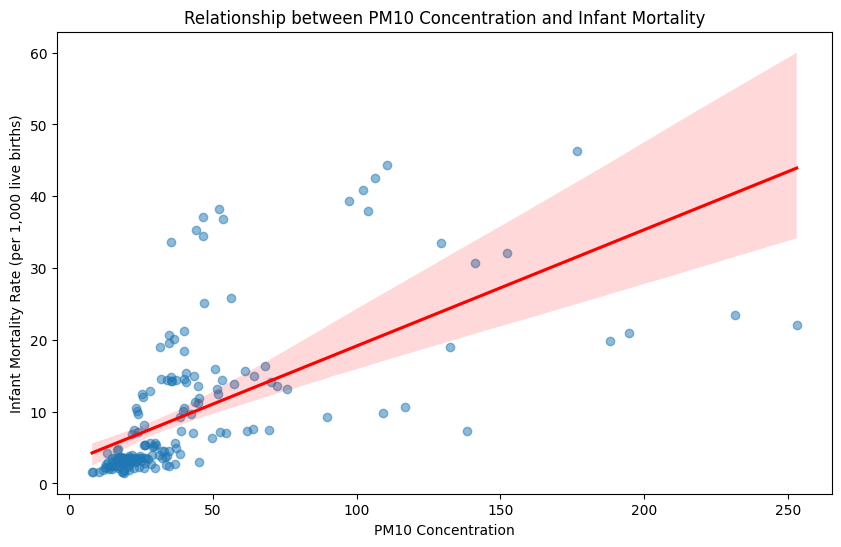

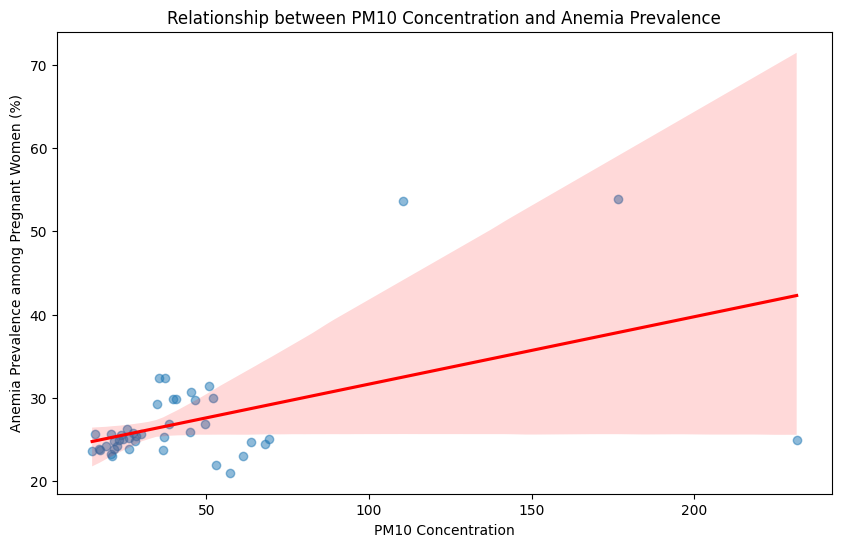

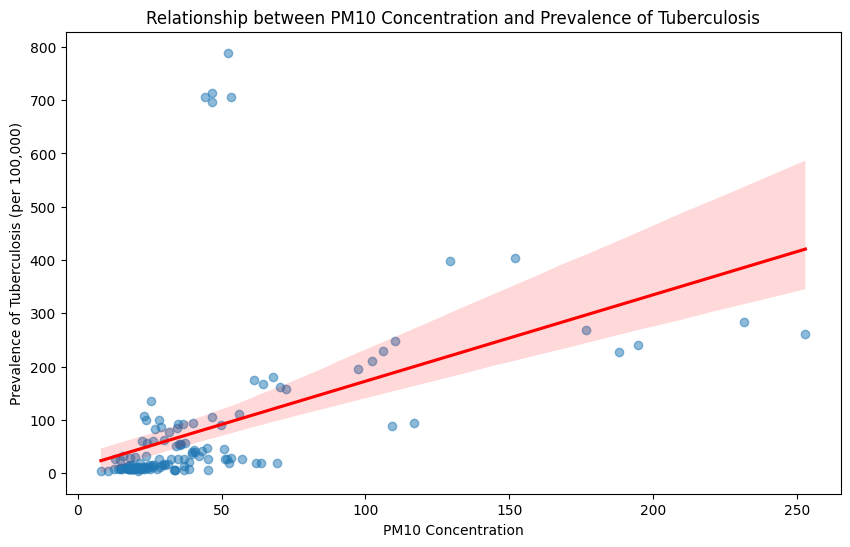

In [ ]:
# Scatterplot for Regression looking at PM10
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
# Infant Mortality and PM10
plt.figure(figsize=(10, 6))
sns.regplot(x='pm10_concentration', y='Mortality rate, infant (per 1,000 live births)', data=df_infant_mortality, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between PM10 Concentration and Infant Mortality')
plt.xlabel('PM10 Concentration')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
plt.show()

# Anemia in Pregnant Women and PM10
plt.figure(figsize=(10, 6))
sns.regplot(x='pm10_concentration', y='Prevalence of anemia among pregnant women (%)', data=df_anemia_pregnant, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between PM10 Concentration and Anemia Prevalence')
plt.xlabel('PM10 Concentration')
plt.ylabel('Anemia Prevalence among Pregnant Women (%)')
plt.show()

# Prevalence of Tuberculosis and PM10
plt.figure(figsize=(10, 6))
sns.regplot(x='pm10_concentration', y='Prevalence of tuberculosis (per 100,000 population)', data=df_tuberculosis, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship between PM10 Concentration and Prevalence of Tuberculosis')
plt.xlabel('PM10 Concentration')
plt.ylabel('Prevalence of Tuberculosis (per 100,000)')
plt.show()

### 2.3.2 Ridge Regression

After establishing the linear regression model, we wanted to address potential overfitting and multicollinearity in by applying regularization through a ridge regression. By adding a penalty to the size of coefficients based on the L2 value, we are help to reduce model complexity and improve the model’s generalization capabilities. Similarly, we used MSE and R^2 values to indicate variance.


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Ridge regression for Infant Mortality Rate
ridge_im = Ridge(alpha=10)
ridge_im.fit(X_train_im, y_train_im)

# Set up predictor
y_pred_im = ridge_im.predict(X_test_im)

# Evaluate model
mse_im = mean_squared_error(y_test_im, y_pred_im)
r2_im = r2_score(y_test_im, y_pred_im)


# Ridge regression for Anemia in Pregnant Women
ridge_ap = Ridge(alpha=10)
ridge_ap.fit(X_train_ap, y_train_ap)

# Set up predictor
y_pred_ap = ridge_ap.predict(X_test_ap)

# Evaluate model
mse_ap = mean_squared_error(y_test_ap, y_pred_ap)
r2_ap = r2_score(y_test_ap, y_pred_ap)


# Ridge regression for Prevalence of Tuberculosis
ridge_tb = Ridge(alpha=10)
ridge_tb.fit(X_train_tb, y_train_tb)

# Set up predictor
y_pred_tb = ridge_tb.predict(X_test_tb)

# Evaluate model
mse_tb = mean_squared_error(y_test_tb, y_pred_tb)
r2_tb = r2_score(y_test_tb, y_pred_tb)

In [ ]:
print(f'Infant Mortality Rate - MSE: {mse_im}, R^2: {r2_im}')
print(f'Anemia in Pregnant Women - MSE: {mse_ap}, R^2: {r2_ap}')
print(f'Prevalence of Tuberculosis: {mse_tb}, R^2: {r2_tb}')

Infant Mortality Rate - MSE: 39.159323676046654, R^2: 0.2527309141100582
Anemia in Pregnant Women - MSE: 24.438529341052945, R^2: -1.6429555884339893
Prevalence of Tuberculosis: 2649.8222463328107, R^2: 0.36994100318304135


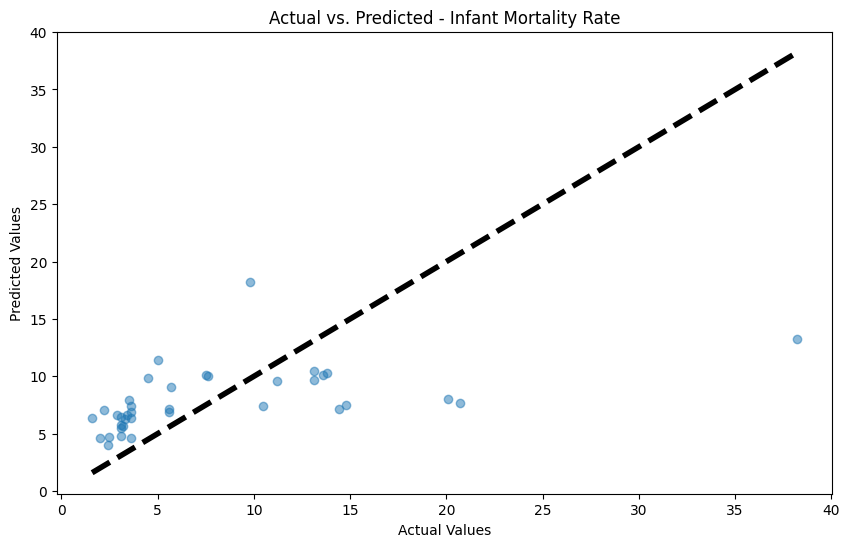

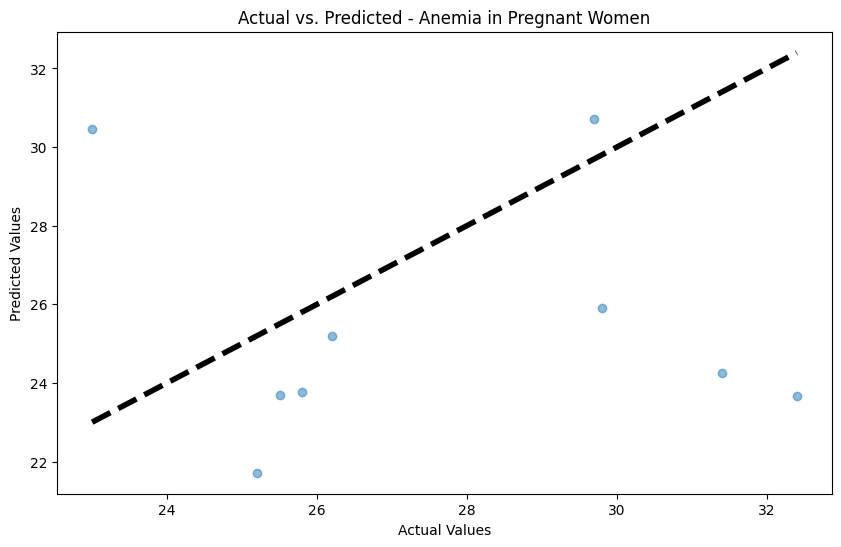

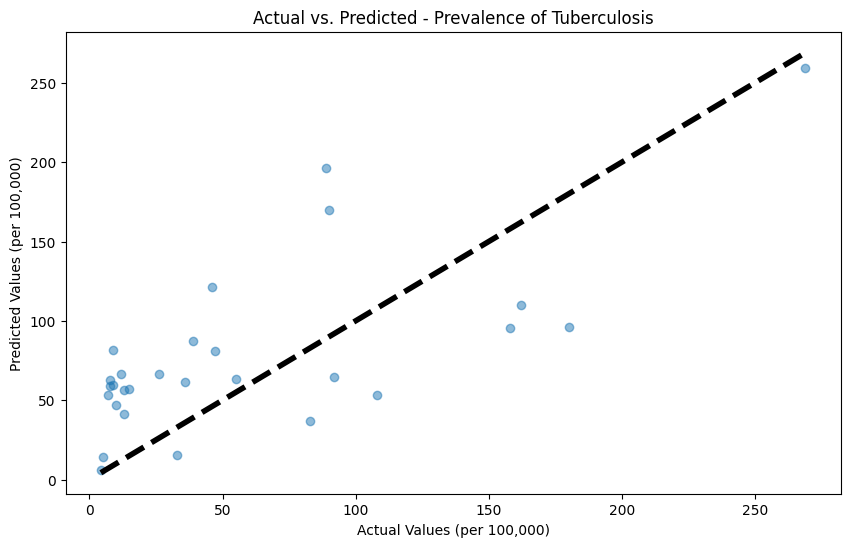

In [ ]:
# Plot Ridge Regression for Infant Mortality Rate
plt.figure(figsize=(10, 6))
plt.scatter(y_test_im, y_pred_im, alpha=0.5)
plt.plot([y_test_im.min(), y_test_im.max()], [y_test_im.min(), y_test_im.max()], 'k--', lw=4)
plt.title('Actual vs. Predicted - Infant Mortality Rate')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot Ridge Regression for Anemia in Pregnant Women
plt.figure(figsize=(10, 6))
plt.scatter(y_test_ap, y_pred_ap, alpha=0.5)
plt.plot([y_test_ap.min(), y_test_ap.max()], [y_test_ap.min(), y_test_ap.max()], 'k--', lw=4)
plt.title('Actual vs. Predicted - Anemia in Pregnant Women')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot Ridge Regression for Prevalence of Tuberculosis
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tb, y_pred_tb, alpha=0.5)
plt.plot([y_test_tb.min(), y_test_tb.max()], [y_test_tb.min(), y_test_tb.max()], 'k--', lw=4)
plt.title('Actual vs. Predicted - Prevalence of Tuberculosis')
plt.xlabel('Actual Values (per 100,000)')
plt.ylabel('Predicted Values (per 100,000)')
plt.show()

### 2.3.3 Random Forest Regression

Finally, we wanted to use a non-linear model that could capture more complex relationships between variables and handle interactions more effectively than the linear model. By using a random forest regression, we are hoping to build a more accurate and stable prediction by having multiple merged decision trees. Similarly, we used MSE and R^2 values to indicate variance.

In [ ]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# Random Forest regression for Infant Mortality Rate
reg_rf_im = RandomForestRegressor(random_state=42)
reg_rf_im.fit(X_train_im, y_train_im)

# Set up predictor
y_pred_im_rf = reg_rf_im.predict(X_test_im)

# Evaluate Model
mse_im_rf = mean_squared_error(y_test_im, y_pred_im_rf)
r2_im_rf = r2_score(y_test_im, y_pred_im_rf)


# Random Forest regression for Anemia in Pregnant Women
reg_rf_ap = RandomForestRegressor(random_state=42)
reg_rf_ap.fit(X_train_ap, y_train_ap)

# Set up predictor
y_pred_ap_rf = reg_rf_ap.predict(X_test_ap)

# Evaluate Model
mse_ap_rf = mean_squared_error(y_test_ap, y_pred_ap_rf)
r2_ap_rf = r2_score(y_test_ap, y_pred_ap_rf)


# Random Forest regression for Prevalence of Tuberculosis
reg_rf_tb = RandomForestRegressor(random_state=42)
reg_rf_tb.fit(X_train_tb, y_train_tb)

# Set up predictor
y_pred_tb_rf = reg_rf_tb.predict(X_test_tb)

# Evaluate Model
mse_tb_rf = mean_squared_error(y_test_tb, y_pred_tb_rf)
r2_tb_rf = r2_score(y_test_tb, y_pred_tb_rf)

In [ ]:
print(f"Random Forest - Infant Mortality Rate: MSE = {mse_im_rf}, R^2 = {r2_im_rf}")
print(f"Random Forest - Anemia in Pregnant Women: MSE = {mse_ap_rf}, R^2 = {r2_ap_rf}")
print(f"Random Forest - Prevalence of Tuberculosis: MSE = {mse_tb_rf}, R^2 = {r2_tb_rf}")

Random Forest - Infant Mortality Rate: MSE = 35.51450372972972, R^2 = 0.3222842417428262
Random Forest - Anemia in Pregnant Women: MSE = 7.808143888888836, R^2 = 0.15557203797164687
Random Forest - Prevalence of Tuberculosis: MSE = 11898.978869035715, R^2 = -1.829268529142396


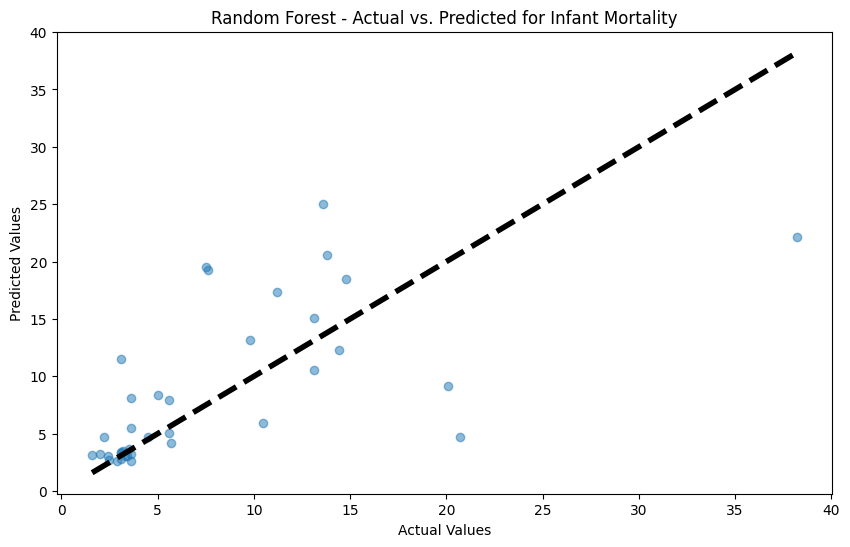

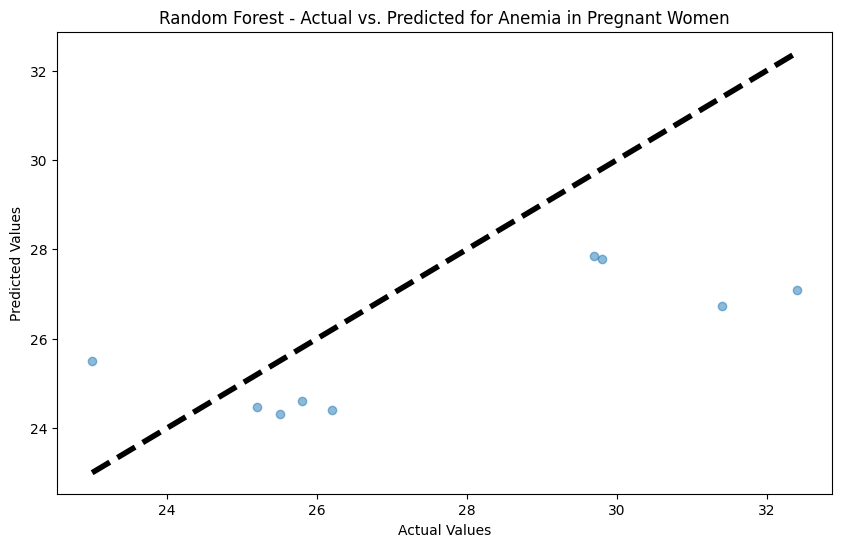

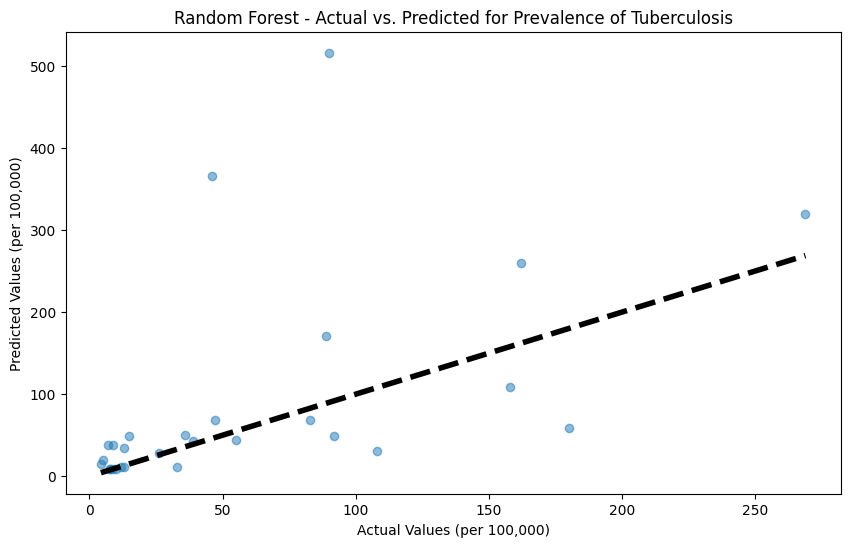

In [ ]:
import matplotlib.pyplot as plt

# Plotting for Infant Mortality
plt.figure(figsize=(10, 6))
plt.scatter(y_test_im, y_pred_im_rf, alpha=0.5)
plt.plot([y_test_im.min(), y_test_im.max()], [y_test_im.min(), y_test_im.max()], 'k--', lw=4)
plt.title('Random Forest - Actual vs. Predicted for Infant Mortality')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plotting for Anemia in Pregnant Women
plt.figure(figsize=(10, 6))
plt.scatter(y_test_ap, y_pred_ap_rf, alpha=0.5)
plt.plot([y_test_ap.min(), y_test_ap.max()], [y_test_ap.min(), y_test_ap.max()], 'k--', lw=4)
plt.title('Random Forest - Actual vs. Predicted for Anemia in Pregnant Women')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plotting for Tuberculosis
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tb, y_pred_tb_rf, alpha=0.5)
plt.plot([y_test_tb.min(), y_test_tb.max()], [y_test_tb.min(), y_test_tb.max()], 'k--', lw=4)
plt.title('Random Forest - Actual vs. Predicted for Prevalence of Tuberculosis')
plt.xlabel('Actual Values (per 100,000)')
plt.ylabel('Predicted Values (per 100,000)')
plt.show()

### 2.3.4 Regression Visualization

Here, we provide a geospatial graph of Infant Mortality Rate vs PM 10 Concentration Regression Coefficients by country. While we are limited by the availability and coverage of the WHO air quality dataset, we nonetheless can identify some regions that air quality may be more severely affecting infant mortality rate such as Eastern Europe. This visualization not only highlights potential areas of concern but also underscores the importance of comprehensive data collection and analysis in understanding the complex interactions between air quality and public health outcomes.

<ipython-input-92-39b34ad11e48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_infant_mortality.dropna(subset=['Country Name','Mortality rate, infant (per 1,000 live births)','pm10_concentration', 'pm25_concentration', 'no2_concentration'],inplace=True)
<ipython-input-92-39b34ad11e48>:48: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = [Polygon(np.array(shape), True)]


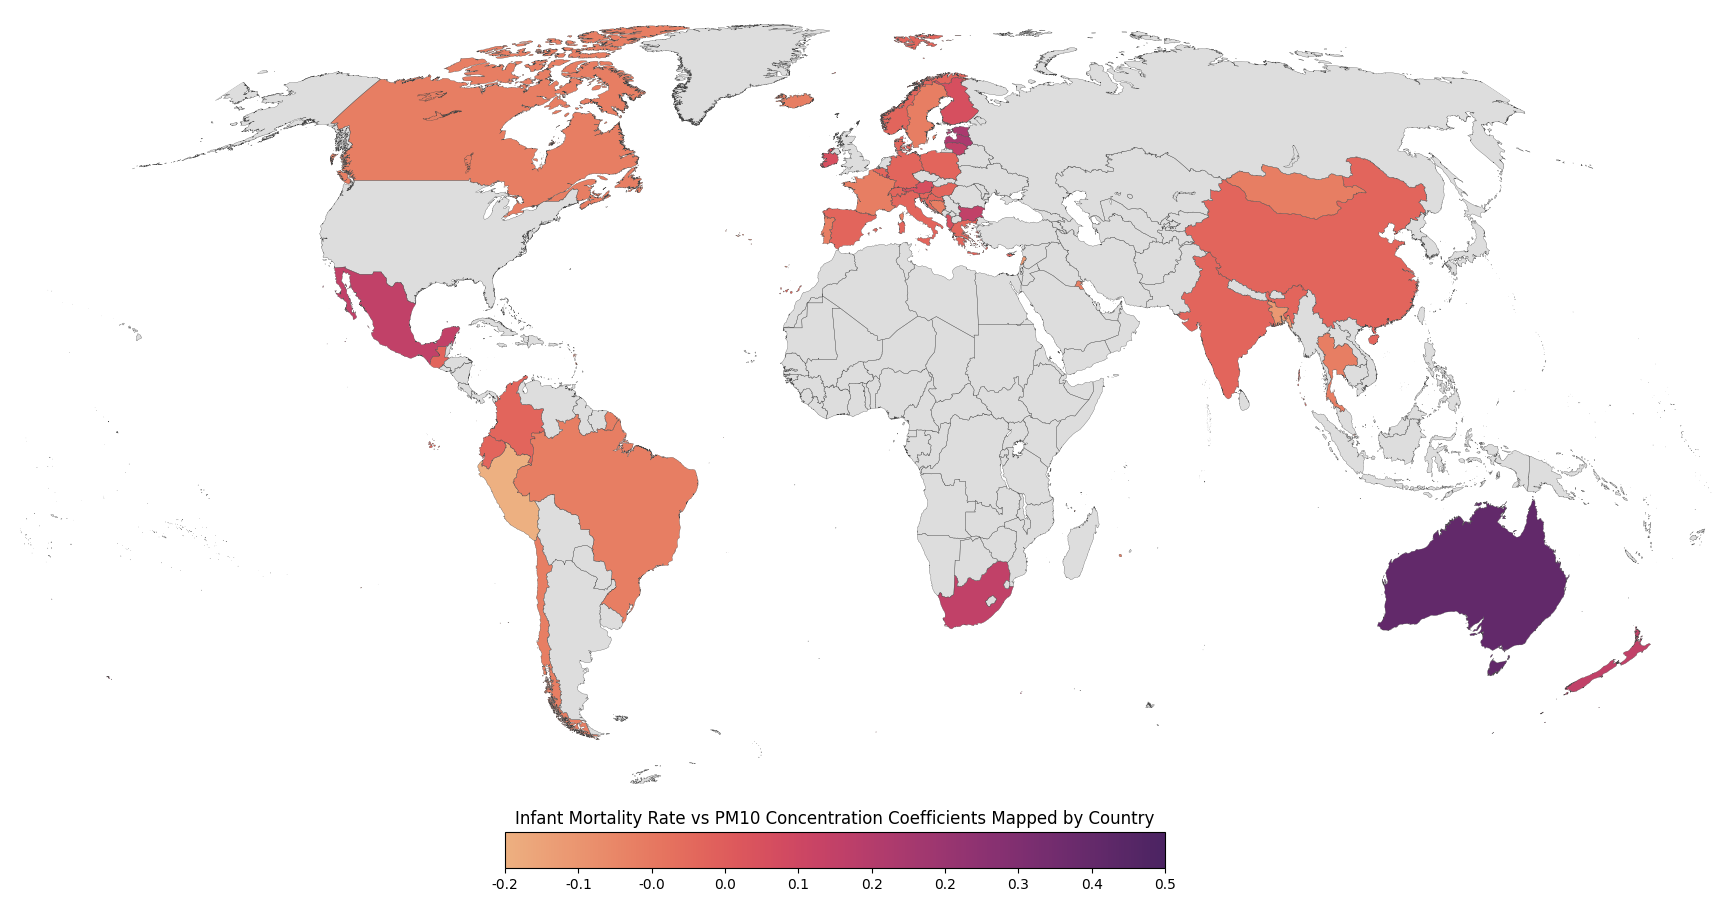

In [ ]:
df_infant_mortality = merged_df[['Country Name','Country Code','Year','Mortality rate, infant (per 1,000 live births)','pm10_concentration', 'pm25_concentration', 'no2_concentration']]
df_infant_mortality.dropna(subset=['Country Name','Mortality rate, infant (per 1,000 live births)','pm10_concentration', 'pm25_concentration', 'no2_concentration'],inplace=True)
X_infant_mortality = df_infant_mortality[['pm10_concentration', 'pm25_concentration', 'no2_concentration']]
y_infant_mortality = df_infant_mortality['Mortality rate, infant (per 1,000 live births)']

grouped_df = df_infant_mortality.groupby(['Country Name','Country Code']).apply(lambda group: LinearRegression().fit(group[['pm10_concentration']], group['Mortality rate, infant (per 1,000 live births)']).coef_[0])

# Create a DataFrame from the grouped results
coefficients_df = pd.DataFrame(grouped_df).reset_index()
coefficients_df.columns = ['Country Name','Country Code', 'coeff_pm10_concentration']

def create_cluster_map(feature, df_map):

    # 1 - INPUTS
    shapefile=('ne_10m_admin_0_countries_lakes')
    num_colors = 10
    cols = ['Country Code', feature]

    # 2 - FILTER COUNTRIES AND GENERATE COLORS

    # Filter countries with country code in GeonamesCache
    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())

    # Create DataFrame
    df_map = df_map.loc[df_map['Country Code'].isin(iso3_codes)].dropna()

    # Generate color bins based on feature
    values = df_map[feature]
    cm = plt.get_cmap('flare')
    scheme = [cm(i / num_colors) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    df_map['bin'] = np.digitize(values, bins) - 1

    # 3 - GENERATE MAP
    fig = plt.figure(figsize=(22, 12))
    ax = fig.add_subplot(111, facecolor='w', frame_on=False)
    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')
    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)

    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in list(df_map['Country Code']):
            color = '#dddddd'
        else:
            color = scheme[df_map.loc[df_map['Country Code']==iso3, 'bin'].values[0]]
        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='horizontal', ticks=bins, cax=fig.add_axes([0.35, 0.14, 0.3, 0.03]))
    cbar.ax.set_xticklabels([str(round(i, 1)) for i in bins])
    plt.title("Infant Mortality Rate vs PM10 Concentration Coefficients Mapped by Country")
    plt.show()

create_cluster_map('coeff_pm10_concentration', coefficients_df)

# Part III: Reflection

## Description of Challenges / Obstacles Faced

There were a wide range of challenges for this data set. The World Bank Health Nutrition and Population Statistics data had an incredible amount of missing data fields. Given how much the values varied by region and time, we did not feel comfortable estimating these values and opted to drop the rows with NULL data. This significantly reduced the number of data points we had for our modeling, but felt that it was better than using estimated values. To increase the number of samples, we waited to drop the rows with null data until we had selected the subset of features to be used in each of the models.

Another challenge came from the shape of the data. The world bank data had the features we wanted to use as values with years as the columns. We needed to flip this to get the data useable for our modeling.

Merging the data also proved difficult. The air quality data was split by cities, but the world health data was organized by countries. We needed to actively group the air data by country by averaging the values across the cities before merging. This may have impacted the results of our models but was the only option available to us.

## Potential Next Steps / Future Direction

Get missing data -- make more models

As our project progresses in evaluating the impact of air quality on health outcomes across diverse demographics, we recognize the importance of enhancing our data collection and analytical methodologies. Our next steps involve obtaining more detailed data that captures fluctuations in health statistics over shorter periods, such as daily or monthly variations. This will allow us to explore temporal effects more thoroughly. Additionally, expanding the geographic scope of our data to include more countries and regions will enhance the robustness and generalizability of our findings. Integrating additional environmental and socioeconomic variables, such as industrial activity levels and comprehensive socioeconomic indicators, will enable us to control for a broader set of confounders and enrich our analyses.

In terms of analytical approaches, we plan to employ advanced statistical techniques capable of more effectively modeling complex interactions and non-linear relationships. The adoption of Generalized Additive Models (GAMs) will provide deeper insights into the dynamics between health metrics and external environmental factors. Furthermore, implementing longitudinal analysis will be crucial for tracking changes over time and assessing the long-term effects of health and environmental policies.

To move beyond correlations and towards causal inferences, we intend to utilize robust statistical methods designed for this purpose, such as propensity score matching and instrumental variable analysis. These methodologies will strengthen our conclusions about the impacts of various factors on health outcomes, supporting more definitive statements.

Augmenting the policy relevance of our research, we plan to develop simulation models that predict the potential impacts of different health and environmental policies. These models will help policymakers understand the possible benefits of proposed interventions. Conducting comprehensive health impact assessments for different populations will provide valuable insights for urban planners and public health officials, aiding in the creation of healthier environments.

Collaboration with public health organizations will be sought to gain access to additional data and expertise, enriching our analysis. Engaging with the academic and professional community through peer-reviewed publications and conference presentations will enhance the credibility and impact of our research. These interactions will not only validate our findings but also provide a platform for receiving valuable feedback. By rigorously pursuing these strategies, our project aims to contribute significantly to the scientific literature and provide practical, data-driven recommendations for public health improvements.